# Prediction of Annual Return from Fundamental Data and Market Cap
Chapter 4 of the book: "Build Your Own AI Investor"

For our investing AI to select stocks for investment it will need to be able to predict which stocks are likely to go up. WIth our X and y data we can train any of the machine learning algorithms to do this. We'll try using all of them and keep the ones that show promise.

In [1]:
# Code from Book: Build Your Own AI Investor
# Damon Lee 2021
# Check out the performance on www.valueinvestingai.com
# Code uses data from the (presumably) nice people at https://simfin.com/. 
# Feel free to fork this code for others to see what can be done with it.

In [2]:
from platform import python_version
print(python_version())

3.9.17


### Imports and Getting Our Data

In [3]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math
from pandas.plotting import scatter_matrix

In [4]:
# Set the plotting DPI settings to be a bit higher.
plt.rcParams['figure.figsize'] = [7.0, 4.5]
plt.rcParams['figure.dpi'] = 150

In [5]:
def loadXandyAgain():
    '''
    Load X and y.
    Randomises rows.
    Returns X, y.
    '''
    # Read in data
    X=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios.csv",
                  index_col=0)
    y=pd.read_csv("Annual_Stock_Price_Performance_Percentage.csv",
                  index_col=0)
    y=y["Perf"] # We only need the % returns as target
    
    # randomize the rows
    X['y'] = y
    X = X.sample(frac=1.0, random_state=42) # randomize the rows
    y = X['y']
    X.drop(columns=['y'], inplace=True)
    
    return X, y

In [6]:
X, y = loadXandyAgain()
y.mean() # Average stock return if we were picking at random.

0.16639832494886286

# Linear Regression
As a start try vanilla linear regression to get the ball rolling.
We use the powertransformer in a pipeline with our linear regressor.

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print('X training matrix dimensions: ', X_train.shape)
print('X testing matrix dimensions: ', X_test.shape)
print('y training matrix dimensions: ', y_train.shape)
print('y testing matrix dimensions: ', y_test.shape)

X training matrix dimensions:  (27947, 18)
X testing matrix dimensions:  (3106, 18)
y training matrix dimensions:  (27947,)
y testing matrix dimensions:  (3106,)


In [8]:
# Try out linear regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

pl_linear = Pipeline([
    ('Power Transformer', PowerTransformer()),
    ('linear', LinearRegression())
    ])

pl_linear.fit(X_train, y_train)
y_pred = pl_linear.predict(X_test)

print('Train MSE: ',
      mean_squared_error(y_train, pl_linear.predict(X_train)))
print('Test MSE: ',
      mean_squared_error(y_test, y_pred))

#import pickle # To save the fitted model
#pickle.dump(pl_linear, open("pl_linear.p", "wb" ))

Train MSE:  1.5495813678348112
Test MSE:  1.0609232401527144


The Errors aren't that good, and they can vary a lot depending on train/test split. Let's try many runs and see if it the regressor is actually learning anything.

In [32]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

sizesToTrain = [0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]   
train_sizes, train_scores, test_scores, fit_times, score_times = \
    learning_curve(pl_linear, X, y, cv=ShuffleSplit(n_splits=100,
                                                    test_size=0.2,
                                                    random_state=42),
                   scoring='neg_mean_squared_error',
                   n_jobs=4, train_sizes=sizesToTrain,
                   return_times=True)

results_df = pd.DataFrame(index=train_sizes) #Create a DataFrame of results
results_df['train_scores_mean'] = np.sqrt(-np.mean(train_scores, axis=1))
results_df['train_scores_std'] = np.std(np.sqrt(-train_scores), axis=1)
results_df['test_scores_mean'] = np.sqrt(-np.mean(test_scores, axis=1))
results_df['test_scores_std'] = np.std(np.sqrt(-test_scores), axis=1)
results_df['fit_times_mean'] = np.mean(fit_times, axis=1)
results_df['fit_times_std'] = np.std(fit_times, axis=1)

In [33]:
results_df # see results

,train_scores_mean,train_scores_std,test_scores_mean,test_scores_std,fit_times_mean,fit_times_std
49,0.657068,0.335235,29995.251535,26766.080397,0.026499,0.006684
124,1.224702,0.846353,21715.205905,19538.137889,0.027959,0.006685
248,1.222206,0.702661,13333.533518,11701.881764,0.030763,0.004601
496,1.212566,0.631669,8685.324449,7762.132147,0.036058,0.006994
1242,1.291643,0.513817,3878.323843,3608.607949,0.047022,0.007201
2484,1.284194,0.352077,1368.461324,1344.612482,0.064909,0.006023
4968,1.227269,0.250290,15.998420,15.292498,0.101957,0.009534
12421,1.228960,0.141423,1.561657,0.738814,0.217952,0.013260


Text(0.5, 1.0, 'Linear Regression Learning Curve')

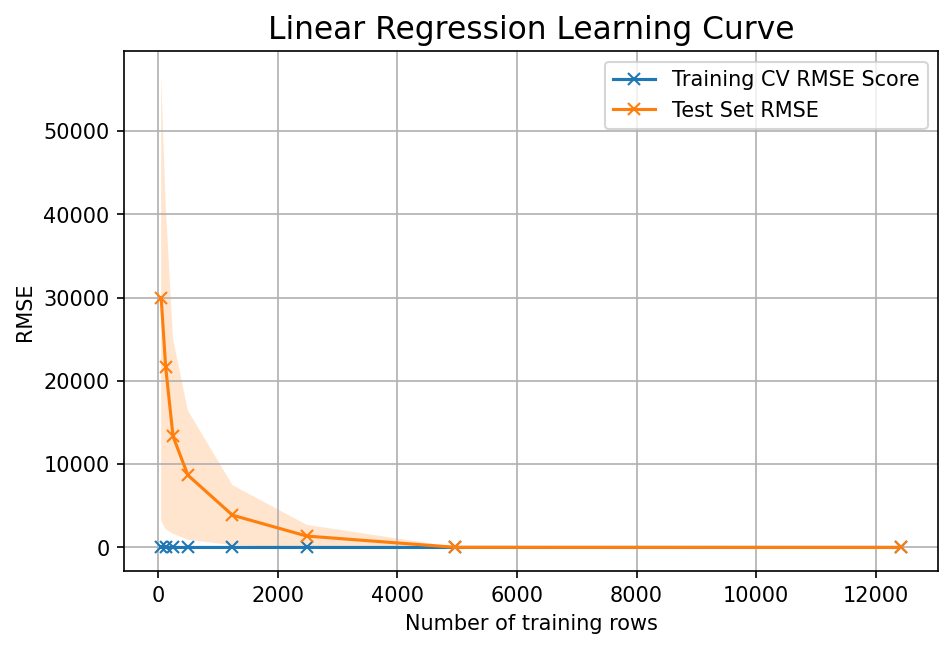

In [36]:
results_df['train_scores_mean'].plot(style='-x')
results_df['test_scores_mean'].plot(style='-x')

plt.fill_between(results_df.index,\
                 results_df['train_scores_mean']-results_df['train_scores_std'],\
                 results_df['train_scores_mean']+results_df['train_scores_std'], alpha=0.2)
plt.fill_between(results_df.index,\
                 results_df['test_scores_mean']-results_df['test_scores_std'],\
                 results_df['test_scores_mean']+results_df['test_scores_std'], alpha=0.2)
plt.grid()
plt.legend(['Training CV RMSE Score','Test Set RMSE'])
plt.ylabel('RMSE')
plt.xlabel('Number of training rows')
plt.title('Linear Regression Learning Curve', fontsize=15)
#plt.ylim([0, 5]);

### Linear Regression Prediction Analysis
Let's see how good our predictions are in a bit more depth. Our AI will be depending on these predictions so we need to be sure stocks can be picked well in this chapter.

#### Plotting Function
To get a better view of how good the predictions are(visually) without depending on mean squared error.

In [49]:
# Output scatter plot and contour plot of density of points to see if prediciton matches reality
# Line of x=y is provided, perfect prediction would have all density on this line
# Also plot linear regression of the scatter

# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def plotDensityContourPredVsReal(model_name, x_plot, y_plot, ps):
    # Plotting scatter 
    plt.scatter(x_plot, y_plot, s=1)
    # Plotting linear regression
    # Swap X and Y fit because prediction is quite centered around one value.
    LinMod = LinearRegression().fit(y_plot.reshape(-1, 1), x_plot.reshape(-1, 1))
    xx=[[-5],[5]]
    yy=LinMod.predict(xx)
    plt.plot(yy,xx,'g')
    # Plot formatting
    plt.grid()
    plt.axhline(y=0, color='r', label='_nolegend_')
    plt.axvline(x=0, color='r', label='_nolegend_')
    plt.xlabel('Predicted Return')
    plt.ylabel('Actual Return')
    plt.plot([-100,100],[-100,100],'y--')
    plt.xlim([-ps,ps])
    plt.ylim([-ps,ps])
    plt.title('Predicted/Actual density plot for {}'.format(model_name))
    plt.legend(['Linear Fit Line','y=x Perfect Prediction Line','Prediction Points'])
    # Save Figure
    #plt.figure(figsize=(5,5))
    plt.savefig('result.png')

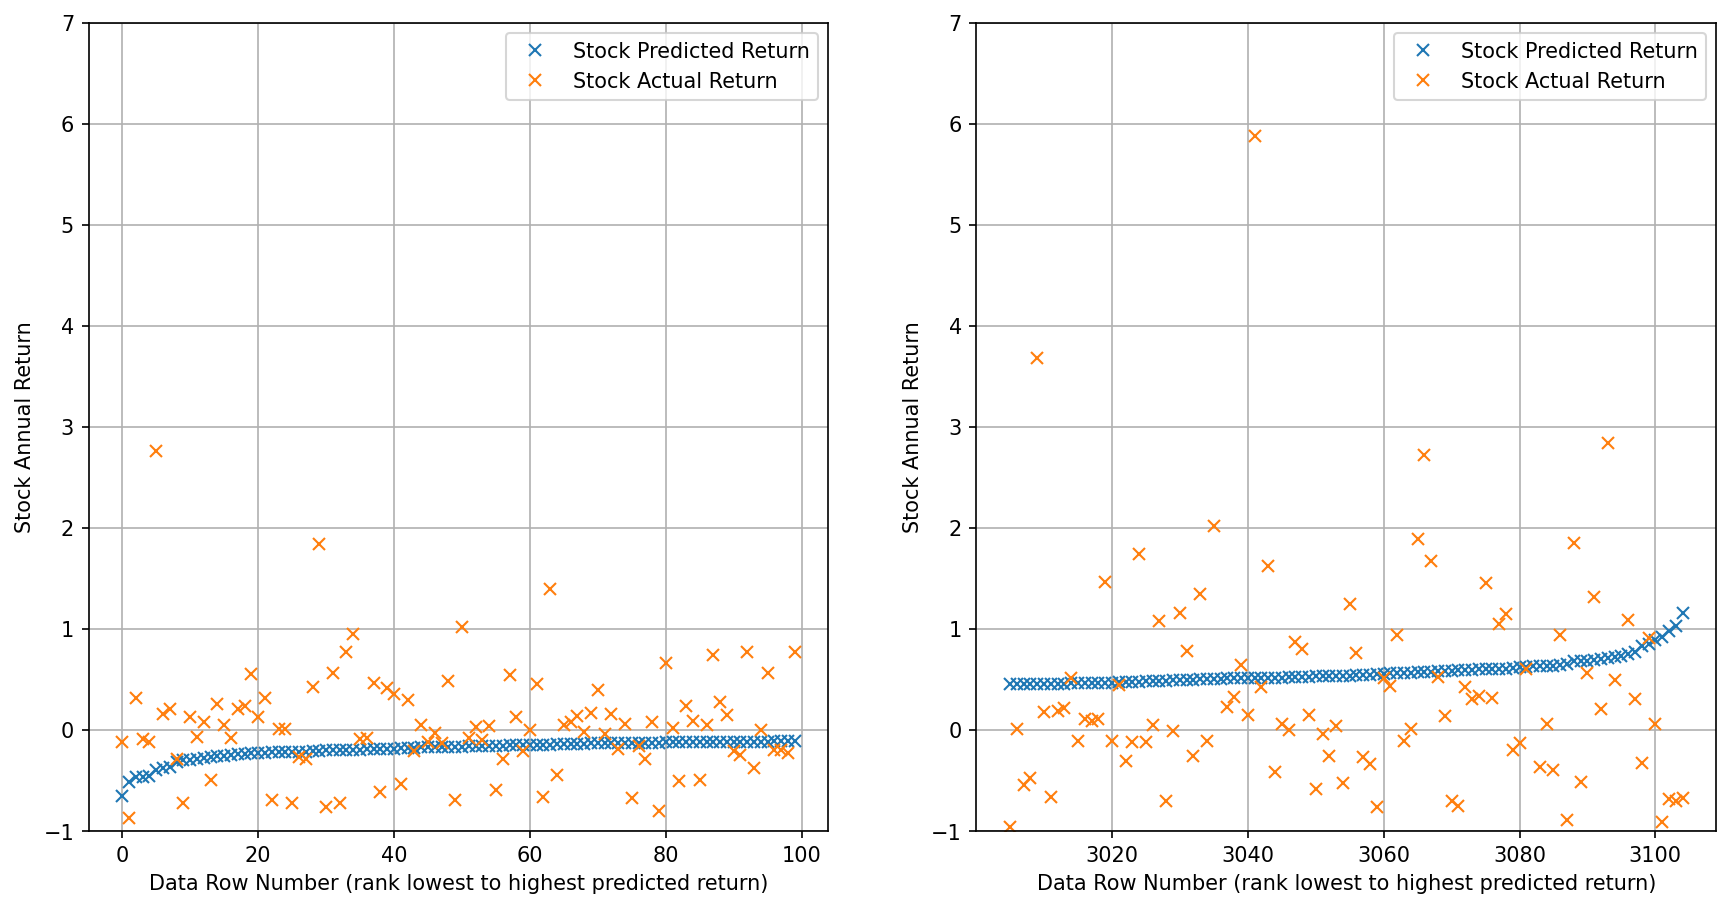

In [50]:
def plotPredictionVsTestDataTopBottom(y_pred, y_test, l=100, plotLimits=[-1,7]):
    comparisonData=pd.DataFrame({'y_pred':y_pred, 
                                 'y_test':y_test}).sort_values(by='y_pred')

    end = comparisonData.shape[0]-1
    start = end - l
    select1 = list(range(0,l)) # 0 to N
    select2 = list(range(start,end)) # last N
    plt.figure(figsize=(14,7))

    plt.subplot(1,2,2)
    plt.plot(select2, comparisonData.iloc[-l:],'x')
    plt.ylim(plotLimits)
    plt.grid()
    plt.ylabel('Stock Annual Return');
    plt.xlabel('Data Row Number (rank lowest to highest predicted return)');
    plt.legend(['Stock Predicted Return',
                'Stock Actual Return', 
                'Mean of actual ']);

    plt.subplot(1,2,1)
    plt.plot(select1, comparisonData.iloc[:l],'x')
    plt.ylim(plotLimits)
    plt.grid()
    plt.ylabel('Stock Annual Return');
    plt.xlabel('Data Row Number (rank lowest to highest predicted return)');
    plt.legend(['Stock Predicted Return',
                'Stock Actual Return']);
    pass

plotPredictionVsTestDataTopBottom(y_pred, y_test, l=100)


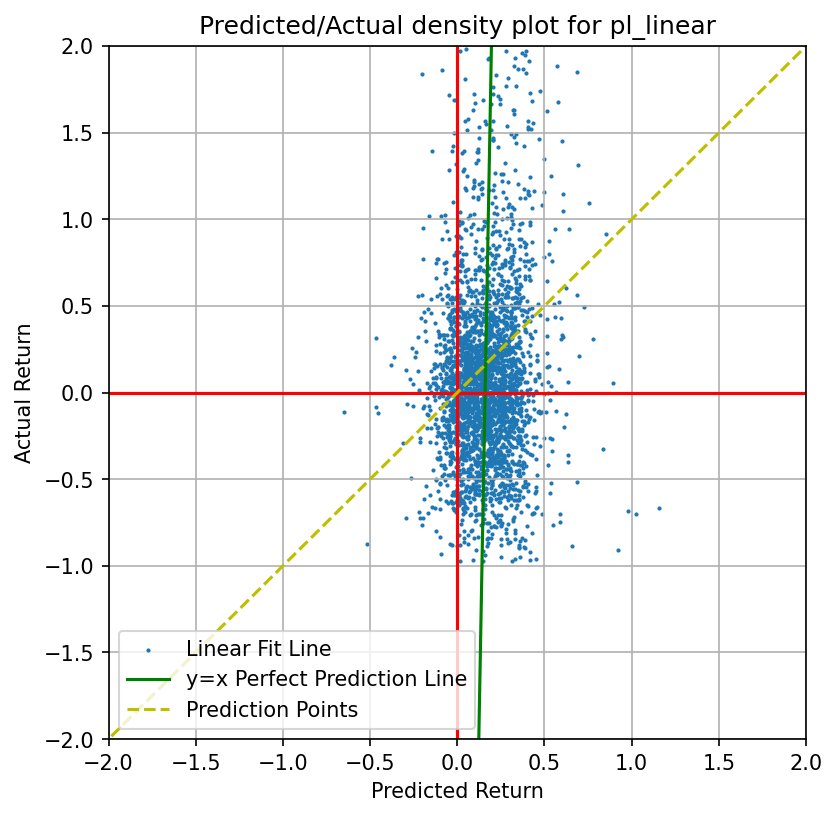

In [51]:
plt.figure(figsize=(6,6))
plotDensityContourPredVsReal('pl_linear', y_pred, y_test.to_numpy(), 2)

It doesn't look so good visually, but there seems to be some ability there. Let's take a closer look by taking our predictors top few stock return predictions and comparing them to reality.

In [52]:
# See top 10 stocks and see how the values differ
# Put results in a DataFrame so we can sort it.
y_results = pd.DataFrame()
y_results['Actual Return'] = y_test
y_results['Predicted Return'] = y_pred

# Sort it by the prediced return.
y_results.sort_values(by='Predicted Return',
                      ascending=False,
                      inplace=True)
y_results.reset_index(drop=True,
                      inplace=True)


print('Predicted Returns:', list(np.round(y_results['Predicted Return'].iloc[:10],2)))
print('Actual Returns:', list(np.round(y_results['Actual Return'].iloc[:10],2)))
print('\nTop 10 Predicted Returns:', round(y_results['Predicted Return'].iloc[:10].mean(),2) , '%','\n')
print('Actual Top 10 Returns:', round(y_results['Actual Return'].iloc[:10].mean(),2) , '%','\n')

Predicted Returns: [1.16, 1.03, 0.98, 0.92, 0.89, 0.85, 0.84, 0.78, 0.75, 0.74]
Actual Returns: [-0.67, -0.7, -0.68, -0.91, 0.06, 0.91, -0.32, 0.31, 1.09, 7.49]

Top 10 Predicted Returns: 0.89 % 

Actual Top 10 Returns: 0.66 % 



Let's try the bottom 10.

In [53]:
# See bottom 10 stocks and see how the values differ
print('\nBottom 10 Predicted Returns:', round(y_results['Predicted Return'].iloc[-10:].mean(),2) , '%','\n')
print('Actual Bottom 10 Returns:', round(y_results['Actual Return'].iloc[-10:].mean(),2) , '%','\n')


Bottom 10 Predicted Returns: -0.43 % 

Actual Bottom 10 Returns: 0.12 % 



There is *some* predictive ability here, it is definately worthwhile using linear regression in the backtest under greater scrutiny later. Don't worry about survivorship bias at this point, we can account for that later, besides these predicted returns are high enough to compensate for that if you look at bankruptcy statistics, and the kinds of stocks being chosen.

Let's try the model with a few more train/test samplings by changing the random_state, and see if the predictive ability stays.

### Try a few Linear Regression runs and see if the top/bottom 10 selections are any good.

In [54]:
def observePredictionAbility(my_pipeline, X, y, returnSomething=False, verbose=True):
    '''
    For a given predictor pipeline.
    Create table of top10/bottom 10 averaged, 
    10 rows of 10 random_states.
    to give us a synthetic performance result.    
    Prints Top and Bottom stock picks
    
    The arguments returnSomething=False, verbose=True,
    will be used at the notebook end to get results.
    '''
    Top10PredRtrns, Top10ActRtrns=[], []
    Bottom10PredRtrns, Bottom10ActRtrns=[], []

    for i in range (0, 10): # Can try 100
        # Pipeline and train/test
        X_train, X_test, y_train, y_test =\
        train_test_split(X, y, test_size=0.1, random_state=42+i)
        my_pipeline.fit(X_train, y_train)
        y_pred = my_pipeline.predict(X_test)
        
        # Put results in a DataFrame so we can sort it.
        y_results = pd.DataFrame()
        y_results['Actual Return'] = y_test
        y_results['Predicted Return'] = y_pred
        
        # Sort it by the prediced return.
        y_results.sort_values(by='Predicted Return',
                              ascending=False,
                              inplace=True)
        y_results.reset_index(drop=True,
                              inplace=True)
        
        
         # See top 10 stocks and see how the values differ
        Top10PredRtrns.append(
            round(np.mean(y_results['Predicted Return'].iloc[:10])*100,
                  2))
        Top10ActRtrns.append(
            round(np.mean(y_results['Actual Return'].iloc[:10])*100,
                  2))
        
        # See bottom 10 stocks and see how the values differ
        Bottom10PredRtrns.append(
            round(np.mean(y_results['Predicted Return'].iloc[-10:])*100,
                  2))
        Bottom10ActRtrns.append(
            round(np.mean(y_results['Actual Return'].iloc[-10:])*100,
                  2))

    if verbose:
        print('Predicted Performance of Top 10 Return Portfolios:', 
              Top10PredRtrns)
        print('Actual Performance of Top 10 Return Portfolios:', 
              Top10ActRtrns,'\n')
        print('Predicted Performance of Bottom 10 Return Portfolios:', 
              Bottom10PredRtrns)
        print('Actual Performance of Bottom 10 Return Portfolios:', 
              Bottom10ActRtrns)
        print('--------------\n')
        
        print('Mean Predicted Std. Dev. of Top 10 Return Portfolios:',
              round(np.array(Top10PredRtrns).std(),2))
        print('Mean Actual Std. Dev. of Top 10 Return Portfolios:',
              round(np.array(Top10ActRtrns).std(),2))
        print('Mean Predicted Std. Dev. of Bottom 10 Return Portfolios:',
              round(np.array(Bottom10PredRtrns).std(),2))
        print('Mean Actual Std. Dev. of Bottom 10 Return Portfolios:',
              round(np.array(Bottom10ActRtrns).std(),2))
        print('--------------\n')
        
        #PERFORMANCE MEASURES HERE
        print(\
        '\033[4mMean Predicted Performance of Top 10 Return Portfolios:\033[0m',\
              round(np.mean(Top10PredRtrns), 2))
        print(\
        '\t\033[4mMean Actual Performance of Top 10 Return Portfolios:\033[0m',\
              round(np.mean(Top10ActRtrns), 2))
        print('Mean Predicted Performance of Bottom 10 Return Portfolios:',\
              round(np.mean(Bottom10PredRtrns), 2))
        print('\tMean Actual Performance of Bottom 10 Return Portfolios:',\
              round(np.mean(Bottom10ActRtrns), 2))
        print('--------------\n')
    
    if returnSomething:
        # Return the top10 and bottom 10 predicted stock return portfolios
        # (the actual performance)
        return Top10ActRtrns, Bottom10ActRtrns
    
    pass

In [55]:
observePredictionAbility(pl_linear, X, y)

Predicted Performance of Top 10 Return Portfolios: [89.25, 72.29, 102.16, 94.94, 105.92, 114.2, 76.92, 108.46, 96.45, 89.45]
Actual Performance of Top 10 Return Portfolios: [65.8, 149.16, 110.46, 50.13, 2.2, 50.59, 474.22, 19.79, -19.49, 107.44] 

Predicted Performance of Bottom 10 Return Portfolios: [-42.97, -44.42, -55.74, -43.1, -56.64, -46.6, -54.52, -51.18, -48.71, -55.54]
Actual Performance of Bottom 10 Return Portfolios: [12.33, -4.85, 17.96, -2.52, 14.46, -19.49, -8.57, -17.37, 25.64, -3.19]
--------------

Mean Predicted Std. Dev. of Top 10 Return Portfolios: 12.76
Mean Actual Std. Dev. of Top 10 Return Portfolios: 133.79
Mean Predicted Std. Dev. of Bottom 10 Return Portfolios: 5.2
Mean Actual Std. Dev. of Bottom 10 Return Portfolios: 14.54
--------------

Mean Predicted Performance of Top 10 Return Portfolios: 95.0
	Mean Actual Performance of Top 10 Return Portfolios: 101.03
Mean Predicted Performance of Bottom 10 Return Portfolios: -49.94
	Mean Actual Performance of Bottom 1

# Elastic Net Regression
Let's see if some regularisation form linear regression will get us better results.

In [56]:
# ElasticNet
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PowerTransformer

pl_ElasticNet = Pipeline([
    ('Power Transformer', PowerTransformer()),
    ('ElasticNet', ElasticNet())#l1_ratio=0.00001, alpha=0.001
])

pl_ElasticNet.fit(X_train, y_train)
y_pred = pl_ElasticNet.predict(X_test)
from sklearn.metrics import mean_squared_error
print('train mse: ', mean_squared_error(y_train, pl_ElasticNet.predict(X_train)))
print('test mse: ', mean_squared_error(y_test, pl_ElasticNet.predict(X_test)))

import pickle
pickle.dump(pl_ElasticNet, open("pl_ElasticNet.p", "wb" ))



train mse:  1.57842789638616
test mse:  1.0733440571353952


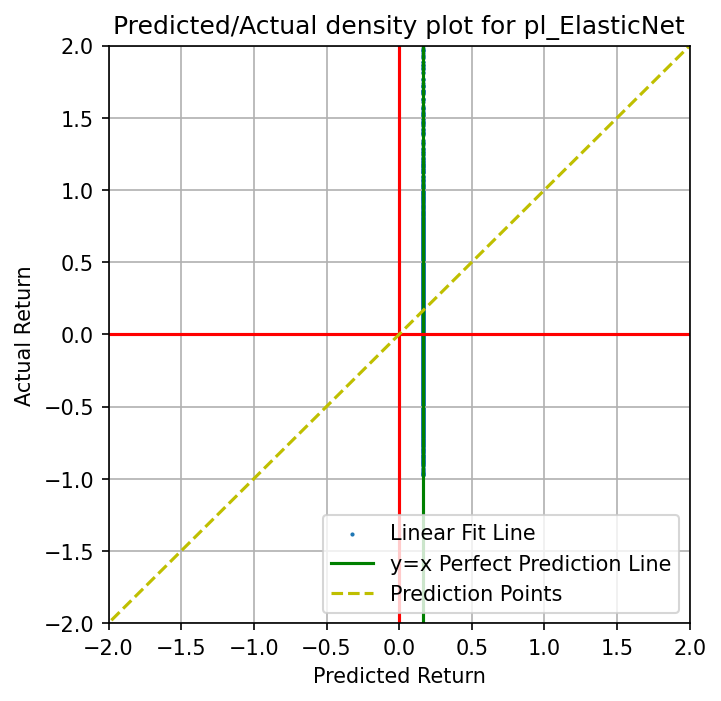

In [57]:
plt.figure(figsize=(5,5))
plotDensityContourPredVsReal('pl_ElasticNet', y_pred, y_test.to_numpy(),2)

### Test some Hyperparameters to try and improve prediction

In [58]:
# ElasticNet
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PowerTransformer

pl_ElasticNet = Pipeline([
    ('Power Transformer', PowerTransformer()),
    ('ElasticNet', ElasticNet(l1_ratio=0.00001))
])

pl_ElasticNet.fit(X_train, y_train)
y_pred_lowL1 = pl_ElasticNet.predict(X_test)
from sklearn.metrics import mean_squared_error
print('train mse: ', mean_squared_error(y_train, pl_ElasticNet.predict(X_train)))
print('test mse: ', mean_squared_error(y_test, pl_ElasticNet.predict(X_test)))

#import pickle
#pickle.dump(pl_ElasticNet, open("pl_ElasticNet.p", "wb" ))

train mse:  1.5601615357471996
test mse:  1.0604388122070578


Text(0.5, 1.0, 'Elasticnet L1 Ratio=0.00001')

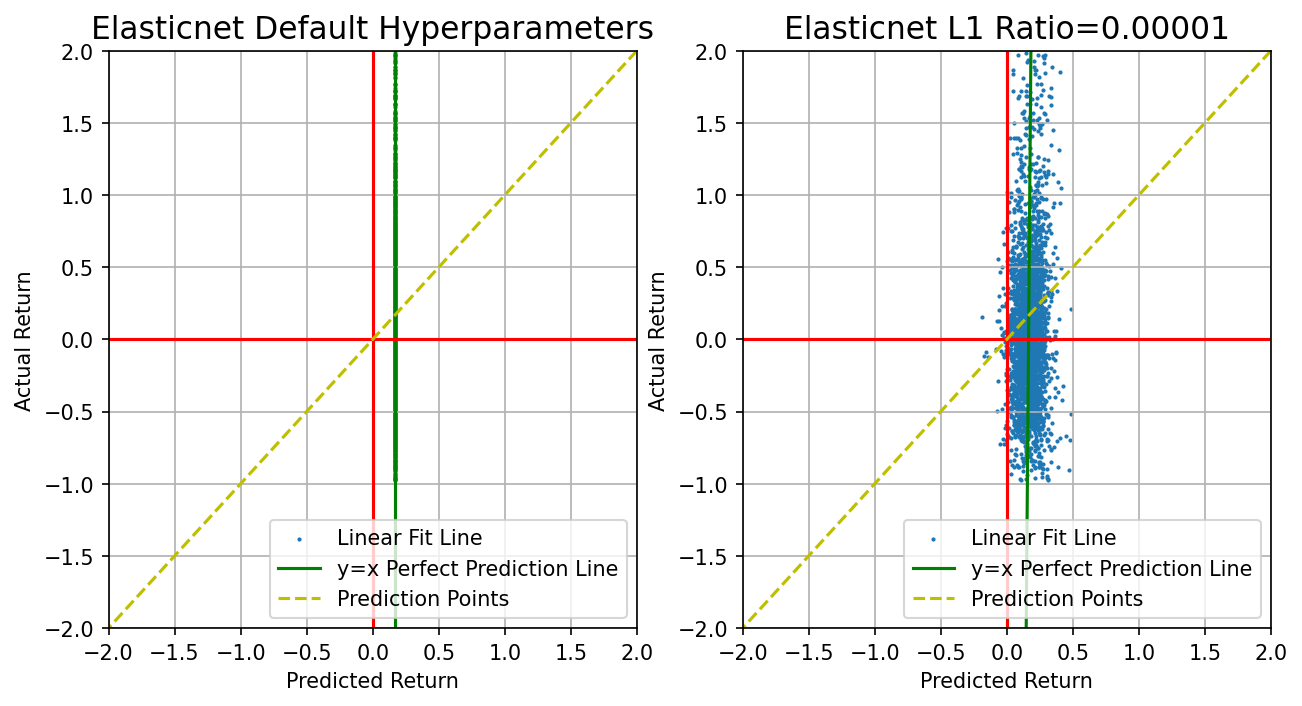

In [59]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plotDensityContourPredVsReal('pl_ElasticNet', y_pred, y_test.to_numpy(),2)
plt.title('Elasticnet Default Hyperparameters',fontsize=15)
plt.subplot(1,2,2)
plotDensityContourPredVsReal('pl_ElasticNet', y_pred_lowL1, y_test.to_numpy(),2)
plt.title('Elasticnet L1 Ratio=0.00001',fontsize=15)

In [60]:
def PrintTopAndBottom10Predictions(y_test, y_pred):
    '''
    See top 10 stocks and see how the values differ.
    Returns nothing.
    '''
    
    # Put results in a DataFrame so we can sort it.
    y_results = pd.DataFrame()
    y_results['Actual Return'] = y_test
    y_results['Predicted Return'] = y_pred

    # Sort it by the prediced return.
    y_results.sort_values(by='Predicted Return',
                          ascending=False,
                          inplace=True)
    y_results.reset_index(drop=True,
                          inplace=True)


    #print('Predicted Returns:', list(np.round(y_results['Predicted Return'].iloc[:10],2)))
    #print('Actual Returns:', list(np.round(y_results['Actual Return'].iloc[:10],2)))
    #Top 10
    print('\nTop 10 Predicted Returns:', round(y_results['Predicted Return'].iloc[:10].mean(),2) , '%','\n')
    print('Actual Top 10 Returns:', round(y_results['Actual Return'].iloc[:10].mean(),2) , '%','\n')
    #Bottom 10
    print('\nBottom 10 Predicted Returns:', round(y_results['Predicted Return'].iloc[-10:].mean(),2) , '%','\n')
    print('Actual Bottom 10 Returns:', round(y_results['Actual Return'].iloc[-10:].mean(),2) , '%','\n')
    
    pass

In [61]:
PrintTopAndBottom10Predictions(y_test, y_pred)


Top 10 Predicted Returns: 0.17 % 

Actual Top 10 Returns: 0.09 % 


Bottom 10 Predicted Returns: 0.17 % 

Actual Bottom 10 Returns: 0.01 % 



### See if the results are repeatable.

In [62]:
observePredictionAbility(pl_ElasticNet, X, y)

Predicted Performance of Top 10 Return Portfolios: [44.26, 42.08, 46.52, 44.74, 47.28, 47.87, 42.77, 44.83, 44.91, 44.02]
Actual Performance of Top 10 Return Portfolios: [10.58, 330.64, 87.25, 195.33, 258.95, 219.35, 201.54, 194.37, -28.74, 138.27] 

Predicted Performance of Bottom 10 Return Portfolios: [-10.74, -16.37, -18.45, -10.69, -17.56, -12.71, -14.21, -13.2, -12.67, -17.76]
Actual Performance of Bottom 10 Return Portfolios: [-0.32, -6.34, 20.59, 3.92, 15.13, -23.18, 2.21, 3.61, -2.95, 12.95]
--------------

Mean Predicted Std. Dev. of Top 10 Return Portfolios: 1.76
Mean Actual Std. Dev. of Top 10 Return Portfolios: 105.02
Mean Predicted Std. Dev. of Bottom 10 Return Portfolios: 2.76
Mean Actual Std. Dev. of Bottom 10 Return Portfolios: 11.72
--------------

Mean Predicted Performance of Top 10 Return Portfolios: 44.93
	Mean Actual Performance of Top 10 Return Portfolios: 160.75
Mean Predicted Performance of Bottom 10 Return Portfolios: -14.44
	Mean Actual Performance of Bottom 

# K Nearest Neighbours Regression

In [63]:
# Read in data and do train/test split.
X, y = loadXandyAgain()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print('X training matrix dimensions: ', X_train.shape)
print('X testing matrix dimensions: ', X_test.shape)
print('y training matrix dimensions: ', y_train.shape)
print('y testing matrix dimensions: ', y_test.shape)

X training matrix dimensions:  (27947, 18)
X testing matrix dimensions:  (3106, 18)
y training matrix dimensions:  (27947,)
y testing matrix dimensions:  (3106,)


In [64]:
# KNeighbors regressor
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PowerTransformer
pl_KNeighbors = Pipeline([
    ('Power Transformer', PowerTransformer()),
    ('KNeighborsRegressor', KNeighborsRegressor(n_neighbors=40))
])

pl_KNeighbors.fit(X_train, y_train)
y_pred = pl_KNeighbors.predict(X_test)
from sklearn.metrics import mean_squared_error
print('train mse: ', mean_squared_error(y_train, pl_KNeighbors.predict(X_train)))
print('test mse: ', mean_squared_error(y_test, y_pred))

import pickle
pickle.dump(pl_KNeighbors, open("pl_KNeighbors.p", "wb" ))

train mse:  1.485317594978198
test mse:  1.0334613230223584


Again the results are fickle depending on the train/test split. Better to see statistical results.

### How does performance change with K? Take a look at Validation curve
Learning curve->See errors as you change the number of training rows

Validation curve->See errors as you change one of the model parameters

In [65]:
knn_validation_list = []
numNeighbours = [4,8,16,32,64,100]
runNum = 40

for i in numNeighbours:
    print('Trying K='+str(i))
    for j in range(0, runNum):
    #Get a new train/test split
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.1,
                                                    random_state=42+j)
        pl_KNeighbors = Pipeline([
            ('Power Transformer', PowerTransformer()),
            ('KNeighborsRegressor', KNeighborsRegressor(n_neighbors=i))
            ]).fit(X_train, y_train)
        
        y_pred = pl_KNeighbors.predict(X_test)
        
        resultThisRun = [i,
            mean_squared_error(y_train, pl_KNeighbors.predict(X_train)),
            mean_squared_error(y_test, y_pred)]
        
        knn_validation_list.append(resultThisRun)

knn_validation_df=pd.DataFrame(knn_validation_list, 
                               columns=['numNeighbours',
                                        'trainError',
                                        'testError'])

Trying K=4
Trying K=8
Trying K=16
Trying K=32
Trying K=64
Trying K=100


In [66]:
knn_validation_df

,numNeighbours,trainError,testError
0,4,1.079857,1.285444
1,4,0.888994,3.774380
2,4,1.119272,0.799577
3,4,1.026293,2.058235
4,4,1.064451,1.654217
...,...,...,...
235,100,1.477471,1.385132
236,100,1.480391,1.391634
237,100,1.529696,0.922190
238,100,1.504289,1.161576


In [67]:
# Get our results in a format we can easily plot
knn_results_list = []
numNeighboursAttempted = knn_validation_df['numNeighbours'].unique()
results_df = pd.DataFrame(index=numNeighboursAttempted) #Create a DataFrame of results

for i in numNeighboursAttempted:
    
    blNeighbours = knn_validation_df['numNeighbours']==i#boolean mask
    
    trainErrorsMean = knn_validation_df[blNeighbours]['trainError'].mean()
    trainErrorsStd = knn_validation_df[blNeighbours]['trainError'].std()
    testErrorsMean = knn_validation_df[blNeighbours]['testError'].mean()
    testErrorsStd = knn_validation_df[blNeighbours]['testError'].std()
    knn_results_list.append([trainErrorsMean, trainErrorsStd,
                            testErrorsMean, testErrorsStd])
    

knn_results_df = pd.DataFrame(knn_results_list,
                              columns=['trainErrorsMean','trainErrorsStd',
                                       'testErrorsMean','testErrorsStd'],
                             index=numNeighboursAttempted)

In [68]:
knn_results_df

,trainErrorsMean,trainErrorsStd,testErrorsMean,testErrorsStd
4,1.051673,0.071020,1.821017,0.920367
8,1.248455,0.085352,1.681332,0.919847
16,1.353803,0.090574,1.594835,0.897119
32,1.412734,0.095704,1.565573,0.902636
64,1.447471,0.097910,1.555536,0.905617
100,1.461483,0.098990,1.554871,0.907195


Text(0.5, 1.0, 'K-NN Validation Curve')

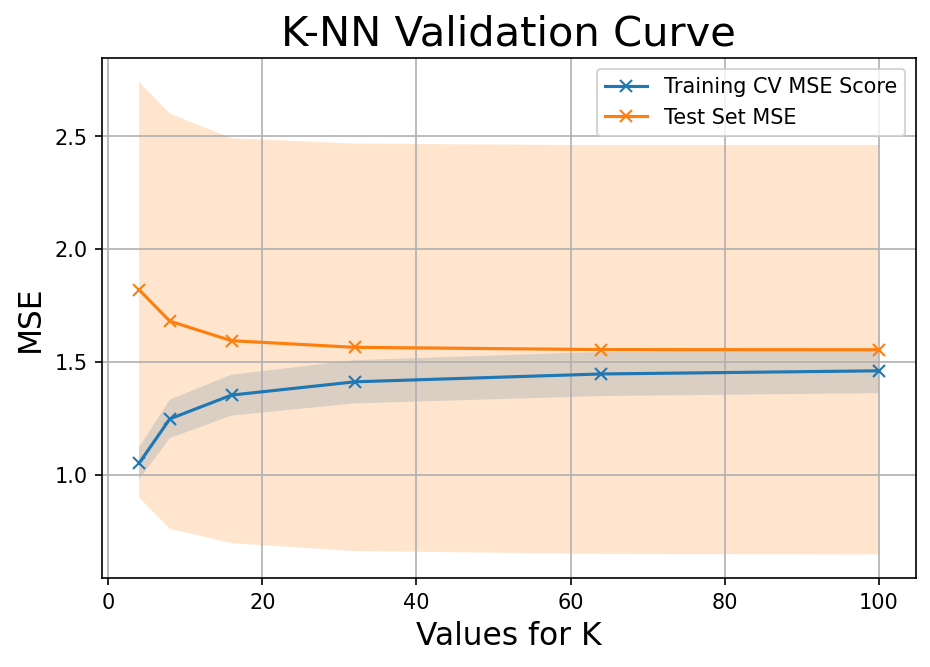

In [69]:
knn_results_df['trainErrorsMean'].plot(style='-x', figsize=(7,4.5))
knn_results_df['testErrorsMean'].plot(style='-x')

plt.fill_between(knn_results_df.index,\
                 knn_results_df['trainErrorsMean']
                 -knn_results_df['trainErrorsStd'],
                 knn_results_df['trainErrorsMean']
                 +knn_results_df['trainErrorsStd'], alpha=0.2)
plt.fill_between(results_df.index,\
                 knn_results_df['testErrorsMean']
                 -knn_results_df['testErrorsStd'],
                 knn_results_df['testErrorsMean']
                 +knn_results_df['testErrorsStd'], alpha=0.2)
plt.grid()
plt.legend(['Training CV MSE Score','Test Set MSE'])
plt.ylabel('MSE', fontsize=15)
plt.xlabel('Values for K', fontsize=15)
plt.title('K-NN Validation Curve', fontsize=20)
#plt.ylim([0, 0.8]);

### Plot the Scatter Graph
See if there is any predictive capability

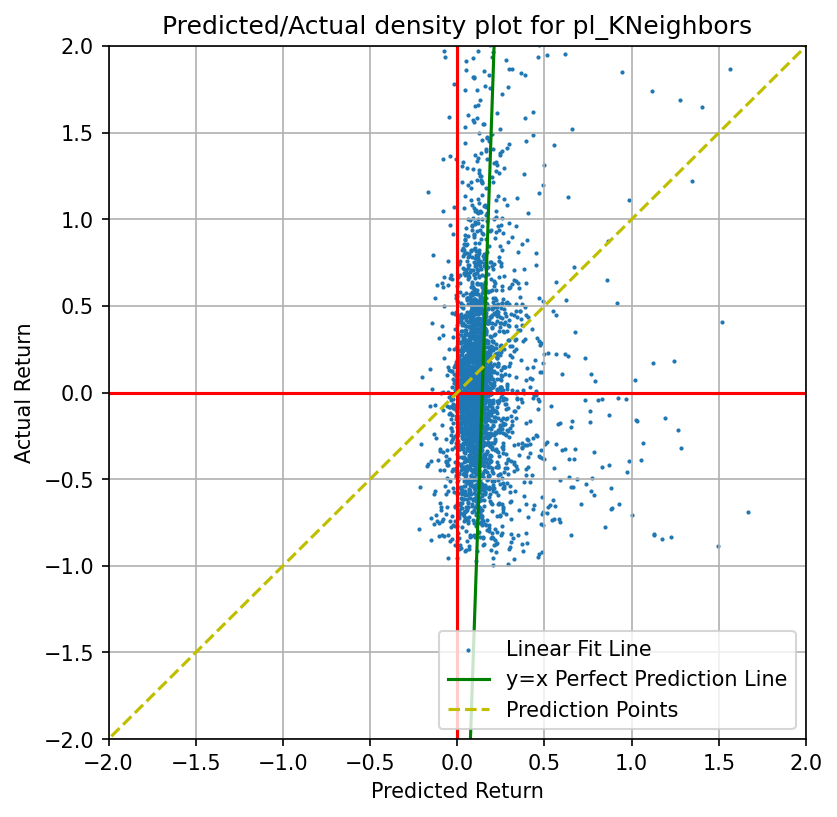

In [70]:
plt.figure(figsize=(6,6))
plotDensityContourPredVsReal('pl_KNeighbors', y_pred, y_test.to_numpy(),2)

Let's take a better look at the scatter graph data. Plotting a kernel density estimator contour over the top

### Investigate predictive ability

In [71]:
# See top 10 stocks and see how the values differ
PrintTopAndBottom10Predictions(y_test, y_pred)


Top 10 Predicted Returns: 1.51 % 

Actual Top 10 Returns: 1.43 % 


Bottom 10 Predicted Returns: -0.18 % 

Actual Bottom 10 Returns: -0.2 % 



In [72]:
observePredictionAbility(pl_KNeighbors, X, y)

Predicted Performance of Top 10 Return Portfolios: [147.33, 127.64, 148.11, 153.3, 153.44, 156.46, 131.51, 157.43, 165.46, 141.11]
Actual Performance of Top 10 Return Portfolios: [122.02, 47.07, 273.3, 68.01, 8.18, 84.3, 99.9, 50.44, 71.96, 105.45] 

Predicted Performance of Bottom 10 Return Portfolios: [-20.2, -17.78, -14.8, -20.18, -22.07, -19.98, -20.13, -16.14, -21.09, -16.21]
Actual Performance of Bottom 10 Return Portfolios: [0.48, -34.16, -22.36, 6.9, -23.92, -27.63, 17.25, -31.55, -5.53, -9.07]
--------------

Mean Predicted Std. Dev. of Top 10 Return Portfolios: 11.21
Mean Actual Std. Dev. of Top 10 Return Portfolios: 67.68
Mean Predicted Std. Dev. of Bottom 10 Return Portfolios: 2.32
Mean Actual Std. Dev. of Bottom 10 Return Portfolios: 16.66
--------------

Mean Predicted Performance of Top 10 Return Portfolios: 148.18
	Mean Actual Performance of Top 10 Return Portfolios: 93.06
Mean Predicted Performance of Bottom 10 Return Portfolios: -18.86
	Mean Actual Performance of Bott

### Investigate predictive ability with KDE plot

In [73]:
# Output scatter plot and contour plot of density of points to see if prediciton matches reality
# Line of x=y is provided, perfect prediction would have all density on this line
# Also plot linear regression of the scatter

# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kde # Need for Kernel Density Calculation
from sklearn.linear_model import LinearRegression

def plotDensityContourPredVsRealContour(model_name, x_plot, y_plot, ps):
#x_plot, y_plot = y_pred, y_test.to_numpy()
    resolution = 40
    # Make a gaussian kde on a grid
    k = kde.gaussian_kde(np.stack([x_plot,y_plot]))
    xi, yi = np.mgrid[-ps:ps:resolution*4j, -ps:ps:resolution*4j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    # Plotting scatter and contour plot
    plt.pcolormesh(xi, 
                   yi, 
                   zi.reshape(xi.shape), 
                   shading='gouraud', 
                   cmap=plt.cm.Greens)
    plt.contour(xi, yi, zi.reshape(xi.shape) )
    plt.scatter(x_plot, y_plot, s=1)
    # Plotting linear regression
    LinMod = LinearRegression()
    LinMod.fit(y_plot.reshape(-1, 1), x_plot.reshape(-1, 1),)
    xx=[[-2],[2]]
    yy=LinMod.predict(xx)
    plt.plot(yy,xx)
    # Plot formatting
    plt.grid()
    plt.axhline(y=0, color='r', label='_nolegend_')
    plt.axvline(x=0, color='r', label='_nolegend_')
    plt.xlabel('Predicted Return')
    plt.ylabel('Actual Return')
    plt.plot([-100,100],[-100,100],'y--')
    plt.xlim([-ps*0.2,ps*0.6]) #
    plt.ylim([-ps,ps])
    plt.title('Predicted/Actual density plot for {}'.format(model_name))
    plt.legend([
        'Linear Fit Line','y=x Perfect Prediction Line',
        'Prediction Points'])
    # Save Figure
    #plt.savefig('result.png')

C:\Users\damon\AppData\Local\Temp\ipykernel_11828\1744760914.py:15: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde(np.stack([x_plot,y_plot]))


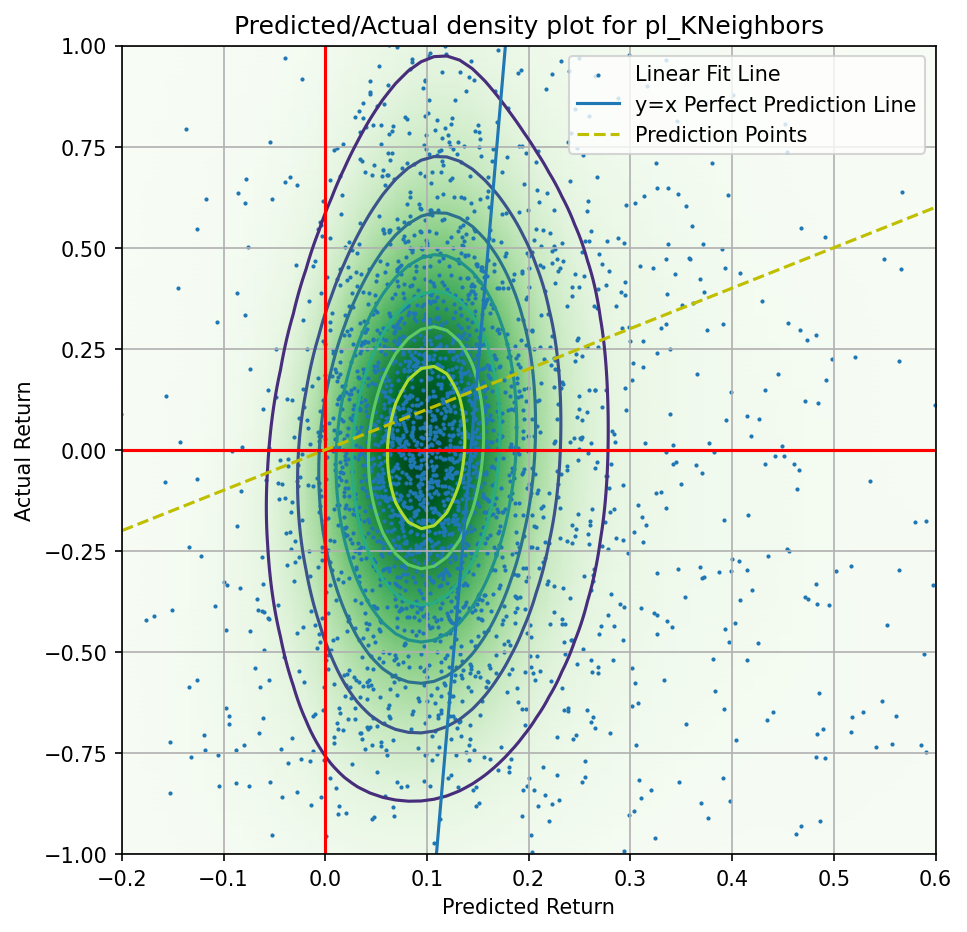

In [74]:
plt.figure(figsize=(7,7))
plotDensityContourPredVsRealContour('pl_KNeighbors', y_pred, y_test.to_numpy(),1)

# Support Vector Machine Regression
Warning: From grid search onward this takes a VERY long time and doesn't do that well relative to training time.
### Quick SVM Regressor with default parameters

In [52]:
# Read in data and do train/test split.
X, y = loadXandyAgain()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print('X training matrix dimensions: ', X_train.shape)
print('X testing matrix dimensions: ', X_test.shape)
print('y training matrix dimensions: ', y_train.shape)
print('y testing matrix dimensions: ', y_test.shape)

X training matrix dimensions:  (14029, 18)
X testing matrix dimensions:  (1559, 18)
y training matrix dimensions:  (14029,)
y testing matrix dimensions:  (1559,)


In [53]:
# SVM quick and dirty
from sklearn.svm import SVR

pl_svm = Pipeline([
    ('Power Transformer', PowerTransformer()),
    ('SVR', SVR()) # kernel='rbf', C=100, gamma=0.1, epsilon=.1 generated good returns. 
])

pl_svm.fit(X_train, y_train)
y_pred = pl_svm.predict(X_test)
from sklearn.metrics import mean_squared_error
print('mse: ', mean_squared_error(y_test, y_pred))
from sklearn.metrics import mean_absolute_error
print('mae: ', mean_absolute_error(y_test, y_pred))

import pickle
pickle.dump(pl_svm, open("pl_svm.p", "wb" ))

mse:  0.2466595706547929
mae:  0.3221255439020061


In [54]:
observePredictionAbility(pl_svm, X, y)

Predicted Performance of Top 10 Return Portfolios: [42.03, 53.61, 48.23, 49.93, 43.88, 46.37, 55.56, 50.74, 49.97, 45.55]
Actual Performance of Top 10 Return Portfolios: [18.93, 27.39, 31.91, 39.07, 13.16, 60.41, -8.01, 6.8, 14.4, 49.01] 

Predicted Performance of Bottom 10 Return Portfolios: [-57.07, -45.21, -50.73, -57.75, -50.83, -43.91, -42.12, -58.57, -56.98, -40.36]
Actual Performance of Bottom 10 Return Portfolios: [14.48, 22.14, 18.34, 17.42, -13.78, 10.94, 32.65, 42.78, 22.87, 138.39]
--------------

Mean Predicted Std. Dev. of Top 10 Return Portfolios: 4.02
Mean Actual Std. Dev. of Top 10 Return Portfolios: 19.47
Mean Predicted Std. Dev. of Bottom 10 Return Portfolios: 6.69
Mean Actual Std. Dev. of Bottom 10 Return Portfolios: 38.53
--------------

Mean Predicted Performance of Top 10 Return Portfolios: 48.59
	Mean Actual Performance of Top 10 Return Portfolios: 25.31
Mean Predicted Performance of Bottom 10 Return Portfolios: -50.35
	Mean Actual Performance of Bottom 10 Retur

### As there are many parameters do a GridSearch CV, to find optimal parameters
We aren't actually aiming for prediction ACCURACY though, we want stock return. Skip this part in the book.

In [55]:
# Takes a LONG time
#Don't run this part unless you really want to grid search.
# best do in parallel

'''from sklearn.model_selection import GridSearchCV

parameters = [{'SVR__kernel': ['linear'],
               'SVR__C': [1, 10, 100],
               'SVR__epsilon': [0.05, 0.1, 0.2]},
                {'SVR__kernel': ['rbf'],
               'SVR__C': [1, 10, 100],
               'SVR__gamma': [0.001, 0.01, 0.1],
               'SVR__epsilon': [0.05, 0.1, 0.2]} ] 

# Best found was C=1, gamma=0.001, epsilon=0.2
svm_gs = GridSearchCV(pl_svm, 
                      parameters, 
                      cv=10, 
                      scoring='neg_mean_squared_error',
                      n_jobs = 4)#parallel

svm_gs.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(svm_gs.best_params_,'\n')
print("Grid scores on development set:")
means = svm_gs.cv_results_['mean_test_score']
stds = svm_gs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, svm_gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))'''

'from sklearn.model_selection import GridSearchCV\n\nparameters = [{\'SVR__kernel\': [\'linear\'],\n               \'SVR__C\': [1, 10, 100],\n               \'SVR__epsilon\': [0.05, 0.1, 0.2]},\n                {\'SVR__kernel\': [\'rbf\'],\n               \'SVR__C\': [1, 10, 100],\n               \'SVR__gamma\': [0.001, 0.01, 0.1],\n               \'SVR__epsilon\': [0.05, 0.1, 0.2]} ] \n\n# Best found was C=1, gamma=0.001, epsilon=0.2\nsvm_gs = GridSearchCV(pl_svm, \n                      parameters, \n                      cv=10, \n                      scoring=\'neg_mean_squared_error\',\n                      n_jobs = 4)#parallel\n\nsvm_gs.fit(X_train, y_train)\n\nprint("Best parameters set found on development set:")\nprint(svm_gs.best_params_,\'\n\')\nprint("Grid scores on development set:")\nmeans = svm_gs.cv_results_[\'mean_test_score\']\nstds = svm_gs.cv_results_[\'std_test_score\']\nfor mean, std, params in zip(means, stds, svm_gs.cv_results_[\'params\']):\n    print("%0.3f (+

mse:  0.23832924510056175
mae:  0.31779941576739307


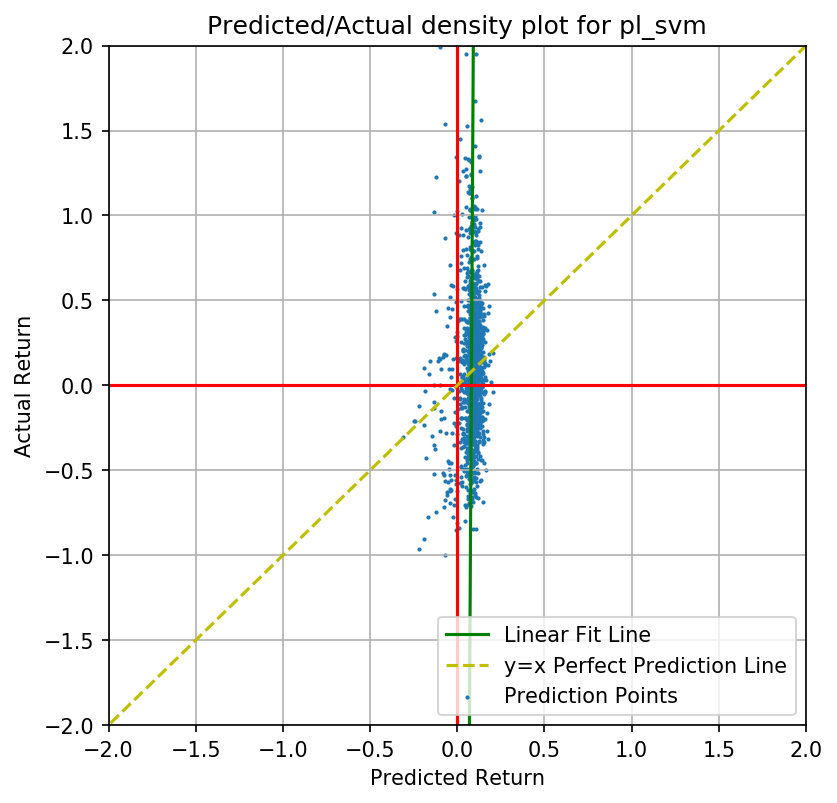

In [56]:
# SVM with (supposedly) optimal parameters
from sklearn.svm import SVR
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

pl_svm = Pipeline([
    ('Power Transformer', PowerTransformer()),
    ('SVR', SVR(kernel='rbf', C=1, gamma=0.001, epsilon=.2)) # Now using optimal parameters (supposedly)
])

pl_svm.fit(X_train, y_train)
y_pred = pl_svm.predict(X_test)
from sklearn.metrics import mean_squared_error
print('mse: ', mean_squared_error(y_test, y_pred))
from sklearn.metrics import mean_absolute_error
print('mae: ', mean_absolute_error(y_test, y_pred))

import pickle
pickle.dump(pl_svm, open("pl_svm.p", "wb" ))

plt.figure(figsize=(6,6))
plotDensityContourPredVsReal('pl_svm', y_pred, y_test.to_numpy(), 2)

In [57]:
observePredictionAbility(pl_svm, X, y)

Predicted Performance of Top 10 Return Portfolios: [18.67, 20.34, 19.24, 18.48, 19.98, 19.47, 18.44, 19.66, 19.27, 19.29]
Actual Performance of Top 10 Return Portfolios: [12.42, 9.19, -6.12, -4.19, 19.75, 5.13, -1.35, 10.58, 8.87, 26.87] 

Predicted Performance of Bottom 10 Return Portfolios: [-22.58, -32.14, -26.75, -20.91, -25.05, -22.3, -24.29, -30.21, -30.01, -26.54]
Actual Performance of Bottom 10 Return Portfolios: [2.15, -15.87, -5.49, -24.14, -35.9, -26.53, -29.74, 32.46, 0.87, 9.43]
--------------

Mean Predicted Std. Dev. of Top 10 Return Portfolios: 0.59
Mean Actual Std. Dev. of Top 10 Return Portfolios: 9.83
Mean Predicted Std. Dev. of Bottom 10 Return Portfolios: 3.57
Mean Actual Std. Dev. of Bottom 10 Return Portfolios: 20.07
--------------

Mean Predicted Performance of Top 10 Return Portfolios: 19.28
	Mean Actual Performance of Top 10 Return Portfolios: 8.11
Mean Predicted Performance of Bottom 10 Return Portfolios: -26.08
	Mean Actual Performance of Bottom 10 Return Po

### Optimal prediction ability may not be optimal for US (Own selected parameters)
yes the prediction coulld be more accurate, but if it is producing lower returns for us then the MSE measure of error isn't really what we want, even if it might tend towards what we want.

In [58]:
def getMyPredictionAbility(my_pipeline, X, y):
    '''
    For a given predictor pipeline.
    Create table of top10 stock picks averaged, 
    and average that over several runs,
    to give us a synthetic performance result.    
    '''
    Top10PredRtrns, Top10ActRtrns=[], []
    Bottom10PredRtrns, Bottom10ActRtrns=[], []
    
    for i in range (0,10):
        # Pipeline and train/test
        X_train, X_test, y_train, y_test =\
        train_test_split(X, y, test_size=0.1, random_state=42+i)
        my_pipeline.fit(X_train, y_train)
        y_pred = my_pipeline.predict(X_test)
        
        # Put results in a DataFrame so we can sort it.
        y_results = pd.DataFrame()
        y_results['Actual Return'] = y_test
        y_results['Predicted Return'] = y_pred
        
        # Sort it by the prediced return.
        y_results.sort_values(by='Predicted Return',
                              ascending=False,
                              inplace=True)
        y_results.reset_index(drop=True,
                              inplace=True)

        # See top 10 stocks and see how the values differ
        Top10PredRtrns.append(round(
                              np.mean(
                              y_results['Predicted Return'].iloc[:10])
                              * 100, 2))
        Top10ActRtrns.append(round(
                             np.mean(
                             y_results['Actual Return'].iloc[:10])
                             * 100, 2))
        
        # See bottom 10 stocks and see how the values differ
        Bottom10PredRtrns.append(round(
                                 np.mean(
                                 y_results['Predicted Return'].iloc[-10:])
                                 * 100, 2))
        Bottom10ActRtrns.append(round(
                                np.mean(
                                y_results['Actual Return'].iloc[-10:])
                                * 100, 2))
        
        # View for debug
        #print([round( np.mean(y_results['Predicted Return'].iloc[:10])*100,2),
        #      round(np.mean(y_results['Actual Return'].iloc[:10])*100,2 ),
        #      round(np.mean(y_results['Predicted Return'].iloc[-10:])*100,2),
        #      round(np.mean(y_results['Actual Return'].iloc[-10:])*100,2 )])
    
    return round(np.mean(Top10ActRtrns),2), \
           round(np.array(Top10ActRtrns).std(),2)

In [59]:
# Iterate through possible hyperparameters and find the combination that gives best return.
# Takes a long time
'''for kern in ['linear', 'rbf']:
    gam_val=0
    if kern == 'linear':
        for C_val in [1, 10, 100]:
            for eps_val in [0.05, 0.1, 0.2]:
                pl_svm = Pipeline([('Power Transformer', PowerTransformer()),\
                            ('SVR', SVR(kernel=kern, C=C_val, epsilon=eps_val)) ])
                performance, certainty = getMyPredictionAbility(pl_svm)
                print('return:', performance, 'std.dev.', certainty,\
                      'For Kernel:', kern, 'C:', C_val, 'Gamma:', gam_val, 'Epsilon', eps_val )
    if kern == 'rbf':
        for C_val in [1, 10, 100]:
            for eps_val in [0.05, 0.1, 0.2]:
                for gam_val in [0.001, 0.01, 0.1]:
                    pl_svm = Pipeline([('Power Transformer', PowerTransformer()),\
                                ('SVR', SVR(kernel=kern, C=C_val, gamma = gam_val, epsilon=eps_val)) ])      
                    performance, certainty = getMyPredictionAbility(pl_svm)
                    print('return:', performance, 'std.dev.', certainty,\
                          'For Kernel:', kern, 'C:', C_val, 'Gamma:', gam_val, 'Epsilon', eps_val )'''


"for kern in ['linear', 'rbf']:\n    gam_val=0\n    if kern == 'linear':\n        for C_val in [1, 10, 100]:\n            for eps_val in [0.05, 0.1, 0.2]:\n                pl_svm = Pipeline([('Power Transformer', PowerTransformer()),                            ('SVR', SVR(kernel=kern, C=C_val, epsilon=eps_val)) ])\n                performance, certainty = getMyPredictionAbility(pl_svm)\n                print('return:', performance, 'std.dev.', certainty,                      'For Kernel:', kern, 'C:', C_val, 'Gamma:', gam_val, 'Epsilon', eps_val )\n    if kern == 'rbf':\n        for C_val in [1, 10, 100]:\n            for eps_val in [0.05, 0.1, 0.2]:\n                for gam_val in [0.001, 0.01, 0.1]:\n                    pl_svm = Pipeline([('Power Transformer', PowerTransformer()),                                ('SVR', SVR(kernel=kern, C=C_val, gamma = gam_val, epsilon=eps_val)) ])      \n                    performance, certainty = getMyPredictionAbility(pl_svm)\n                   

In [60]:
# SVM that gives higher stock returns.
from sklearn.svm import SVR

pl_svm = Pipeline([
    ('Power Transformer', PowerTransformer()),
    ('SVR', SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)) # best hyperparameter results
])

pl_svm.fit(X_train, y_train)
y_pred = pl_svm.predict(X_test)
from sklearn.metrics import mean_squared_error
print('mse: ', mean_squared_error(y_test, y_pred))
from sklearn.metrics import mean_absolute_error
print('mae: ', mean_absolute_error(y_test, y_pred))

import pickle
pickle.dump(pl_svm, open("pl_svm.p", "wb" ))

mse:  0.349765242784621
mae:  0.39231482833053893


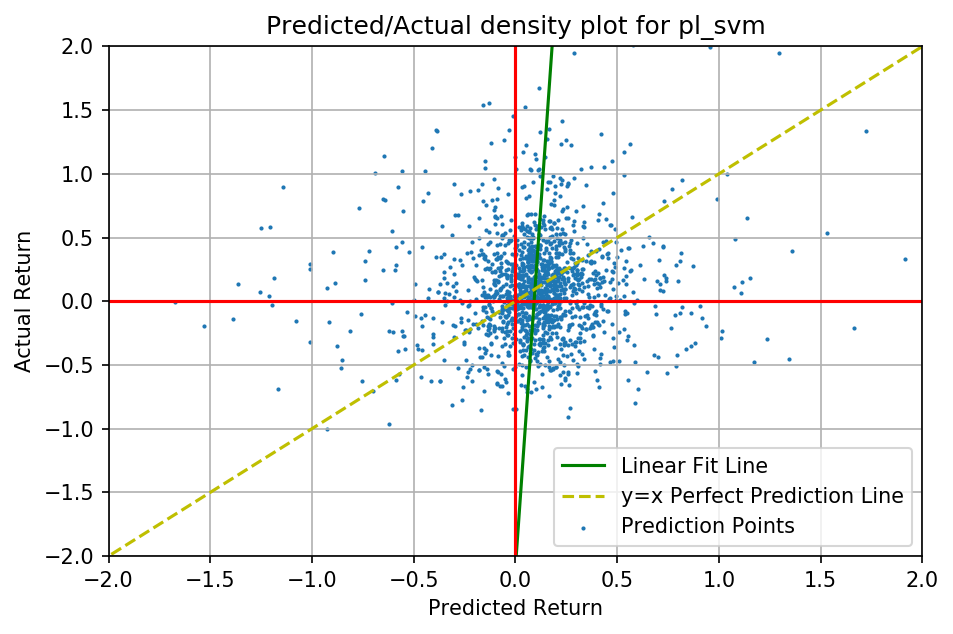

In [61]:
plotDensityContourPredVsReal('pl_svm', y_pred, y_test.to_numpy(), 2)

In [62]:
# See top 10 stocks and see how the values differ
PrintTopAndBottom10Predictions(y_test, y_pred)


Top 10 Predicted Returns: 1.92 % 

Actual Top 10 Returns: 0.39 % 


Bottom 10 Predicted Returns: -1.83 % 

Actual Bottom 10 Returns: 0.02 % 



In [63]:
observePredictionAbility(pl_svm, X, y)

Predicted Performance of Top 10 Return Portfolios: [192.49, 337.96, 259.8, 258.02, 208.24, 244.8, 267.92, 346.43, 236.19, 395.77]
Actual Performance of Top 10 Return Portfolios: [39.1, 7.7, 30.04, 36.14, 3.5, -4.08, -7.5, 24.9, 211.94, 41.69] 

Predicted Performance of Bottom 10 Return Portfolios: [-182.64, -174.74, -177.94, -171.63, -189.29, -158.43, -161.11, -175.55, -152.59, -136.39]
Actual Performance of Bottom 10 Return Portfolios: [1.84, -17.4, 18.21, 35.81, 17.93, 0.47, -7.2, 36.98, 43.76, -4.07]
--------------

Mean Predicted Std. Dev. of Top 10 Return Portfolios: 61.57
Mean Actual Std. Dev. of Top 10 Return Portfolios: 60.38
Mean Predicted Std. Dev. of Bottom 10 Return Portfolios: 15.03
Mean Actual Std. Dev. of Bottom 10 Return Portfolios: 19.99
--------------

Mean Predicted Performance of Top 10 Return Portfolios: 274.76
	Mean Actual Performance of Top 10 Return Portfolios: 38.34
Mean Predicted Performance of Bottom 10 Return Portfolios: -168.03
	Mean Actual Performance of B

# Decision Tree Regression

In [64]:
# Read in data and do train/test split.
X, y = loadXandyAgain()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print('X training matrix dimensions: ', X_train.shape)
print('X testing matrix dimensions: ', X_test.shape)
print('y training matrix dimensions: ', y_train.shape)
print('y testing matrix dimensions: ', y_test.shape)

X training matrix dimensions:  (14029, 18)
X testing matrix dimensions:  (1559, 18)
y training matrix dimensions:  (14029,)
y testing matrix dimensions:  (1559,)


In [65]:
# DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

pl_decTree = Pipeline([
    ('DecisionTreeRegressor',
     DecisionTreeRegressor(random_state=42)) # no need scaler
])

pl_decTree.fit(X_train, y_train)
y_pred = pl_decTree.predict(X_test)
from sklearn.metrics import mean_squared_error
print('train mse: ', 
      mean_squared_error(y_train, 
                         pl_decTree.predict(X_train)))
print('test mse: ',
      mean_squared_error(y_test, y_pred))

import pickle
pickle.dump(pl_decTree, open("pl_decTree.p", "wb" ))

train mse:  4.269176435974926e-10
test mse:  0.5173096468024905


That train error looks VERY low, it's likely overfitted. let's create a learning curve and find a good value for max_depth

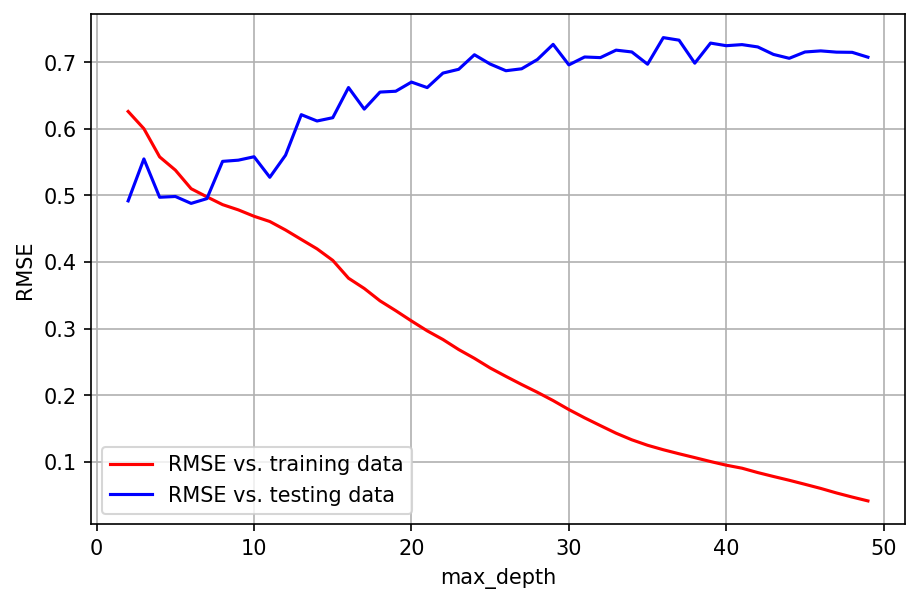

In [66]:
train_errors, test_errors, test_sizes=[], [], []

for i in range(2,50):
    pl_decTree = Pipeline([
    ('DecisionTreeRegressor', DecisionTreeRegressor(random_state=42, max_depth=i))])
    pl_decTree.fit(X_train, y_train)
    y_pred = pl_decTree.predict(X_test)
    train_errors.append(mean_squared_error(y_train, pl_decTree.predict(X_train)))
    test_errors.append(mean_squared_error(y_test, y_pred))
    test_sizes.append(i)

plt.plot(test_sizes, np.sqrt(train_errors),'r',test_sizes, np.sqrt(test_errors),'b')
plt.legend(['RMSE vs. training data','RMSE vs. testing data'])
plt.grid()
#plt.ylim([0,0.6])
plt.ylabel('RMSE');
plt.xlabel('max_depth');

We can't just choose a max_depth of 40+ because it is obviously overfitting there. The error vs. the training data is unfortunately not coming towards the error vs. testing data, so a lower tree depth is desirable, bt we can't choose a very low number, remember there are 15 columns to our x matrix (and possibly more if you have generated your own ratios).

We'll settle on a tree_depth of 10. Any less and we will obviously be utilising too little of our data, yet the error between test and training sets is reasonably close.

### Try max_depth of 10

In [67]:
# DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

pl_decTree = Pipeline([
    ('DecisionTreeRegressor', DecisionTreeRegressor(random_state=42, max_depth=10))
])

pl_decTree.fit(X_train, y_train)
y_pred = pl_decTree.predict(X_test)
from sklearn.metrics import mean_squared_error
print('train mse: ', mean_squared_error(y_train, pl_decTree.predict(X_train)))
print('test mse: ', mean_squared_error(y_test, y_pred))

import pickle
pickle.dump(pl_decTree, open("pl_decTree.p", "wb" ))

train mse:  0.21951367088692858
test mse:  0.31123535150405224


In [68]:
observePredictionAbility(pl_decTree, X, y)

Predicted Performance of Top 10 Return Portfolios: [253.47, 315.12, 277.65, 169.93, 675.56, 672.41, 244.59, 479.94, 498.54, 296.2]
Actual Performance of Top 10 Return Portfolios: [0.95, 2.69, -5.94, 57.4, 67.45, 76.42, -5.55, 5.77, -10.7, -19.07] 

Predicted Performance of Bottom 10 Return Portfolios: [-56.34, -67.89, -68.96, -53.85, -68.13, -44.81, -58.05, -73.45, -68.95, -52.5]
Actual Performance of Bottom 10 Return Portfolios: [-21.77, 13.79, 8.52, 29.34, 35.97, 3.31, -23.73, -19.4, 33.51, -18.42]
--------------

Mean Predicted Std. Dev. of Top 10 Return Portfolios: 172.16
Mean Actual Std. Dev. of Top 10 Return Portfolios: 33.76
Mean Predicted Std. Dev. of Bottom 10 Return Portfolios: 8.92
Mean Actual Std. Dev. of Bottom 10 Return Portfolios: 22.66
--------------

Mean Predicted Performance of Top 10 Return Portfolios: 388.34
	Mean Actual Performance of Top 10 Return Portfolios: 16.94
Mean Predicted Performance of Bottom 10 Return Portfolios: -61.29
	Mean Actual Performance of Botto

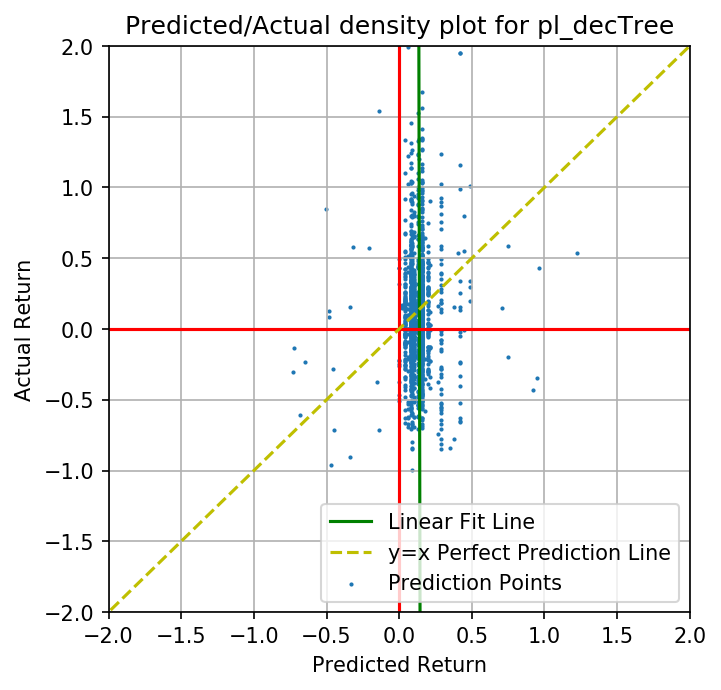

In [69]:
plt.figure(figsize=(5,5))
plotDensityContourPredVsReal('pl_decTree', y_pred, y_test.to_numpy(),2)

### K-Fold cross validation
We'll want to check how repeatable the decision tree regressor is. 

In [70]:
from sklearn.model_selection import cross_validate

pl_decTree = Pipeline([
    ('DecisionTreeRegressor', DecisionTreeRegressor(random_state=42, max_depth=10))])

scores = cross_validate(pl_decTree, X, y, scoring='neg_mean_squared_error', cv=10, return_train_score=True)
print('K=10 Segments.')
print('Train scores', np.round(np.sqrt(-scores['train_score']), 2) )
print('Test scores', np.round(np.sqrt(-scores['test_score']), 2) )
print('-----------------')
print('AVERAGE TEST SCORE:', round(np.sqrt(-scores['test_score']).mean(),4),\
     'STD. DEV.:', round(np.sqrt(-scores['test_score']).std(),4))
print('AVERAGE TRAIN SCORE:', round(np.sqrt(-scores['train_score']).mean(),4),\
     'STD. DEV.:', round(np.sqrt(-scores['train_score']).std(),4))
print('-----------------')

K=10 Segments.
Train scores [0.46 0.47 0.44 0.43 0.47 0.45 0.48 0.44 0.44 0.46]
Test scores [1.05 0.74 0.58 0.61 0.62 0.85 0.63 0.75 0.8  0.63]
-----------------
AVERAGE TEST SCORE: 0.727 STD. DEV.: 0.1392
AVERAGE TRAIN SCORE: 0.4532 STD. DEV.: 0.0156
-----------------


Seems consistent, see if returns are consistent.

### Investigate Predictive Ability
What max tree depth shall we use?

In [71]:
for my_depth in [4,5,6,7,8,9,10,15,20,30,50]:
    decTree = DecisionTreeRegressor(random_state=42, max_depth=my_depth) # no need scaler
    performance, certainty = getMyPredictionAbility(decTree, X, y)
    print('Tree max_depth:', my_depth, 
          'Average Return:',  performance,
          'Standard Deviation:', certainty)

Tree max_depth: 4 Average Return: 25.33 Standard Deviation: 37.34
Tree max_depth: 5 Average Return: 38.19 Standard Deviation: 62.07
Tree max_depth: 6 Average Return: 46.63 Standard Deviation: 65.1
Tree max_depth: 7 Average Return: 41.45 Standard Deviation: 54.91
Tree max_depth: 8 Average Return: 34.47 Standard Deviation: 53.89
Tree max_depth: 9 Average Return: 15.94 Standard Deviation: 26.49
Tree max_depth: 10 Average Return: 16.94 Standard Deviation: 33.76
Tree max_depth: 15 Average Return: 24.97 Standard Deviation: 33.35
Tree max_depth: 20 Average Return: 29.16 Standard Deviation: 45.88
Tree max_depth: 30 Average Return: 26.37 Standard Deviation: 28.03
Tree max_depth: 50 Average Return: 31.58 Standard Deviation: 36.24


### Use max_depth of 15

In [72]:
# DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

pl_decTree = Pipeline([
    ('DecisionTreeRegressor', DecisionTreeRegressor(random_state=42, max_depth=15))
])

pl_decTree.fit(X_train, y_train)
y_pred = pl_decTree.predict(X_test)
from sklearn.metrics import mean_squared_error
print('train mse: ', mean_squared_error(y_train, pl_decTree.predict(X_train)))
print('test mse: ', mean_squared_error(y_test, y_pred))

import pickle
pickle.dump(pl_decTree, open("pl_decTree.p", "wb" ))

train mse:  0.1618507211457791
test mse:  0.38006636499785257


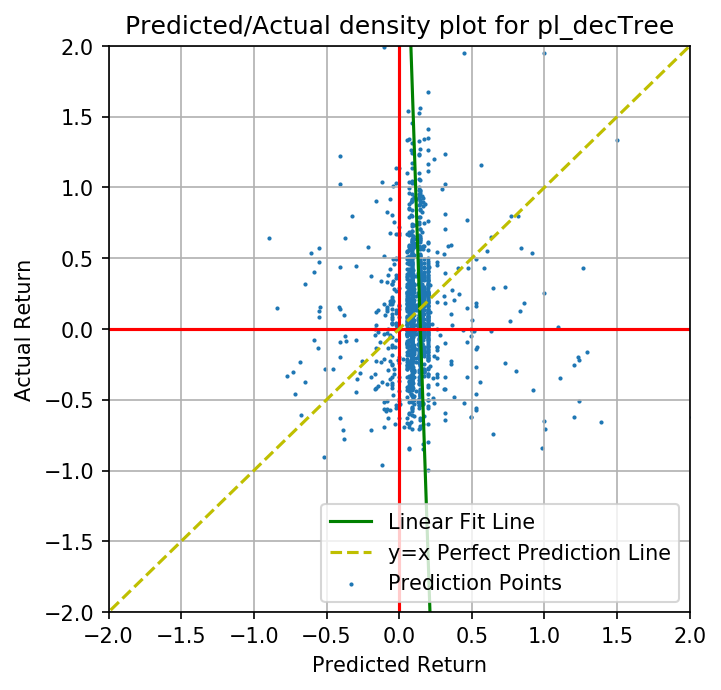

In [73]:
plt.figure(figsize=(5,5))
plotDensityContourPredVsReal('pl_decTree', y_pred, y_test.to_numpy(),2)

In [74]:
PrintTopAndBottom10Predictions(y_test, y_pred)


Top 10 Predicted Returns: 3.7 % 

Actual Top 10 Returns: -0.19 % 


Bottom 10 Predicted Returns: -0.72 % 

Actual Bottom 10 Returns: -0.07 % 



In [75]:
observePredictionAbility(pl_decTree, X, y)

Predicted Performance of Top 10 Return Portfolios: [370.2, 333.28, 351.2, 399.45, 692.7, 702.31, 259.02, 734.34, 656.18, 365.56]
Actual Performance of Top 10 Return Portfolios: [-18.52, 1.76, 3.96, 25.2, 97.11, 59.76, -8.53, 39.01, 41.0, 8.95] 

Predicted Performance of Bottom 10 Return Portfolios: [-72.13, -76.11, -85.97, -71.96, -82.47, -76.96, -86.46, -81.6, -88.93, -84.73]
Actual Performance of Bottom 10 Return Portfolios: [-6.55, 22.4, 17.35, -29.47, 71.63, -13.61, -23.36, -8.56, 23.37, 18.95]
--------------

Mean Predicted Std. Dev. of Top 10 Return Portfolios: 175.66
Mean Actual Std. Dev. of Top 10 Return Portfolios: 33.35
Mean Predicted Std. Dev. of Bottom 10 Return Portfolios: 5.78
Mean Actual Std. Dev. of Bottom 10 Return Portfolios: 28.34
--------------

Mean Predicted Performance of Top 10 Return Portfolios: 486.42
	Mean Actual Performance of Top 10 Return Portfolios: 24.97
Mean Predicted Performance of Bottom 10 Return Portfolios: -80.73
	Mean Actual Performance of Bottom 

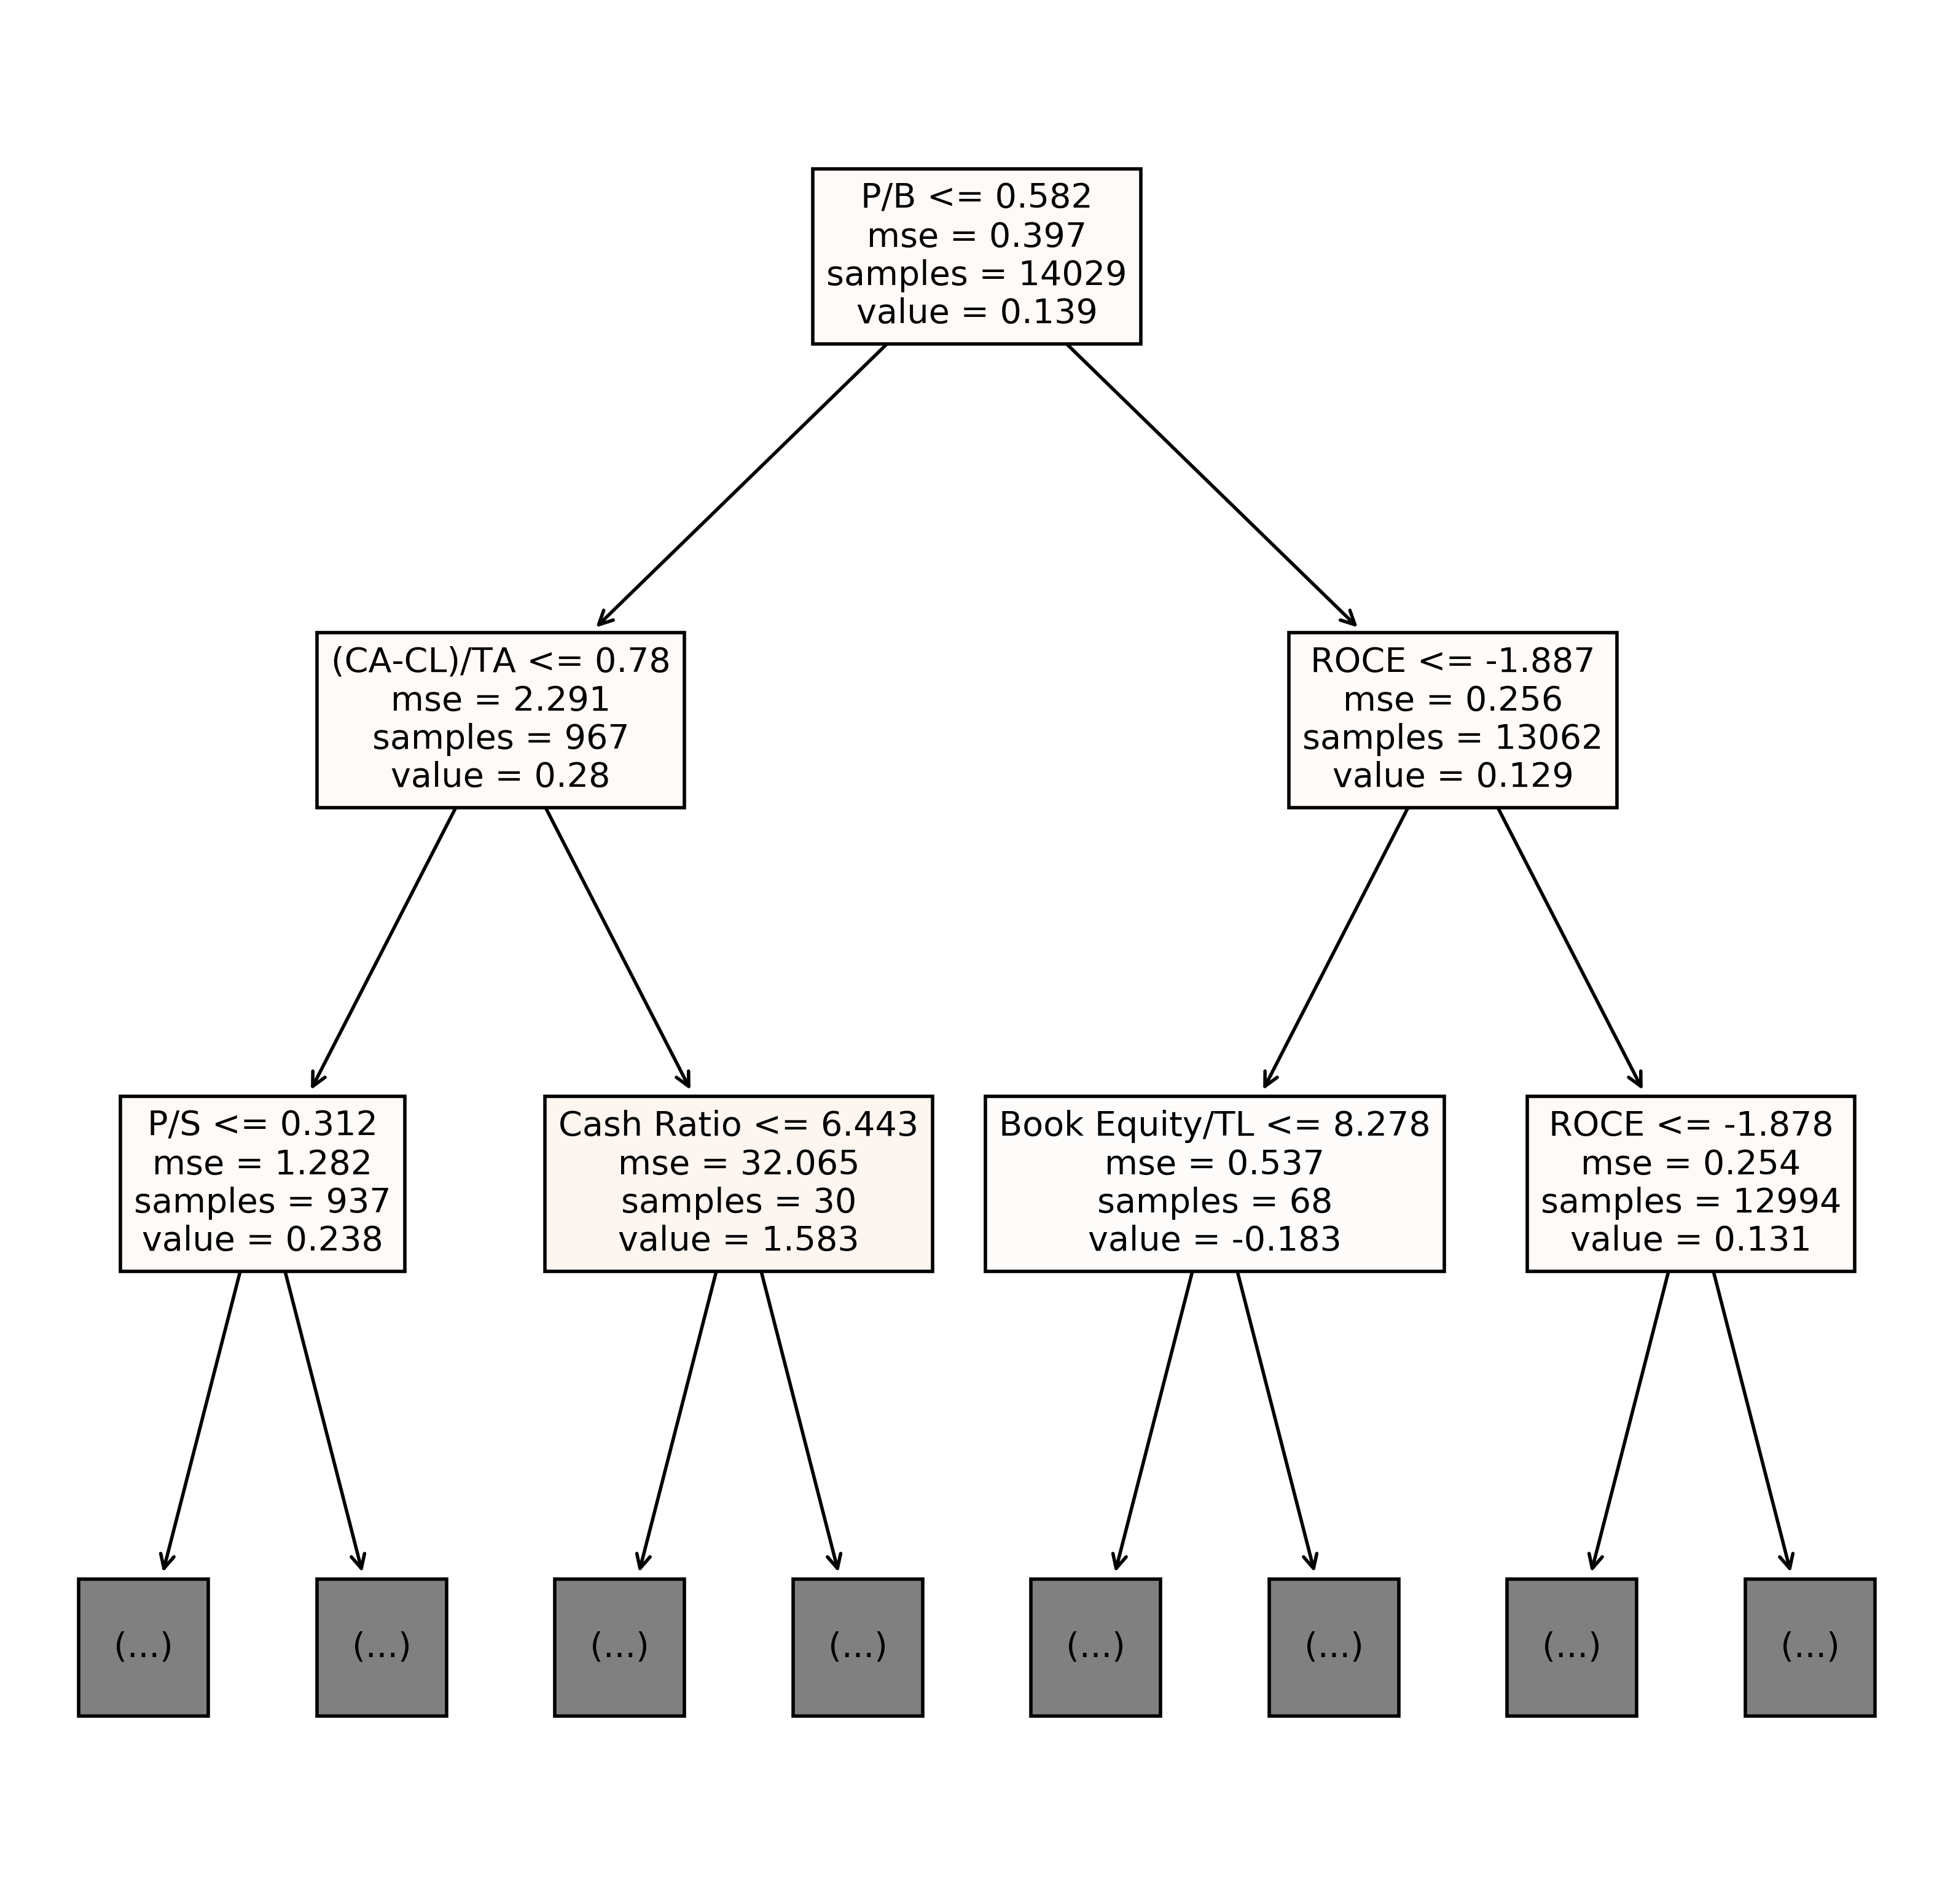

In [76]:
# See the decision tree
reg_decTree = DecisionTreeRegressor(random_state=42, max_depth=40)
reg_decTree.fit(X_train, y_train)
from sklearn import tree # Need this to see decision tree.
plt.figure(figsize=(10,10), dpi=400) # set figsize so we can see it
tree.plot_tree(reg_decTree, feature_names = X.keys(),  filled = True, max_depth=2, fontsize=10);
plt.savefig('RegDecTree.png')

# Random Forest Regression

In [77]:
# Read in data and do train/test split.
X, y = loadXandyAgain()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print('X training matrix dimensions: ', X_train.shape)
print('X testing matrix dimensions: ', X_test.shape)
print('y training matrix dimensions: ', y_train.shape)
print('y testing matrix dimensions: ', y_test.shape)

X training matrix dimensions:  (14029, 18)
X testing matrix dimensions:  (1559, 18)
y training matrix dimensions:  (14029,)
y testing matrix dimensions:  (1559,)


In [78]:
from sklearn.ensemble import RandomForestRegressor
#for my_depth in [4, 6, 10, 16, 24]: # faster
for my_depth in range(4,21):
    rForest = RandomForestRegressor(random_state=42, max_depth=my_depth) # no need scaler
    performance, certainty = getMyPredictionAbility(rForest, X, y)
    print('Tree max_depth:', my_depth, 
          'Average Return:', performance,
          'Standard Deviation:', certainty)

Tree max_depth: 4 Average Return: 47.38 Standard Deviation: 62.52
Tree max_depth: 5 Average Return: 60.6 Standard Deviation: 59.6
Tree max_depth: 6 Average Return: 58.64 Standard Deviation: 65.03
Tree max_depth: 7 Average Return: 60.2 Standard Deviation: 61.1
Tree max_depth: 8 Average Return: 40.49 Standard Deviation: 64.12
Tree max_depth: 9 Average Return: 37.11 Standard Deviation: 58.64
Tree max_depth: 10 Average Return: 40.34 Standard Deviation: 59.46
Tree max_depth: 11 Average Return: 50.05 Standard Deviation: 78.67
Tree max_depth: 12 Average Return: 42.55 Standard Deviation: 62.1
Tree max_depth: 13 Average Return: 34.73 Standard Deviation: 61.61
Tree max_depth: 14 Average Return: 43.12 Standard Deviation: 69.77
Tree max_depth: 15 Average Return: 41.14 Standard Deviation: 60.89
Tree max_depth: 16 Average Return: 50.91 Standard Deviation: 74.12
Tree max_depth: 17 Average Return: 42.97 Standard Deviation: 62.81
Tree max_depth: 18 Average Return: 45.19 Standard Deviation: 69.55
Tree m

In [79]:
from sklearn.ensemble import RandomForestRegressor
rfregressor = RandomForestRegressor(random_state=42, max_depth=10)
rfregressor.fit(X_train, y_train)
y_pred = rfregressor.predict(X_test)

print('train mse: ', 
      mean_squared_error(y_train, 
                         rfregressor.predict(X_train)))
print('test mse: ',
      mean_squared_error(y_test, 
                         y_pred))

import pickle
pickle.dump(rfregressor, open("pl_rfregressor.p", "wb" ))

train mse:  0.20971718040583018
test mse:  0.2622593995036744


In [80]:
from sklearn.ensemble import ExtraTreesRegressor
ETregressor = ExtraTreesRegressor(random_state=42, max_depth=10)
ETregressor.fit(X_train, y_train)
y_pred_ET = ETregressor.predict(X_test)
print('train mse: ', 
      mean_squared_error(y_train, 
                         ETregressor.predict(X_train)))
print('test mse: ', 
      mean_squared_error(y_test, 
                         y_pred_ET))

import pickle
pickle.dump(ETregressor, open("pl_ETregressor.p", "wb" ))

train mse:  0.21982249603645046
test mse:  0.2933175190727553


Text(0.5, 1, 'Extra (Random) Trees Regressor')

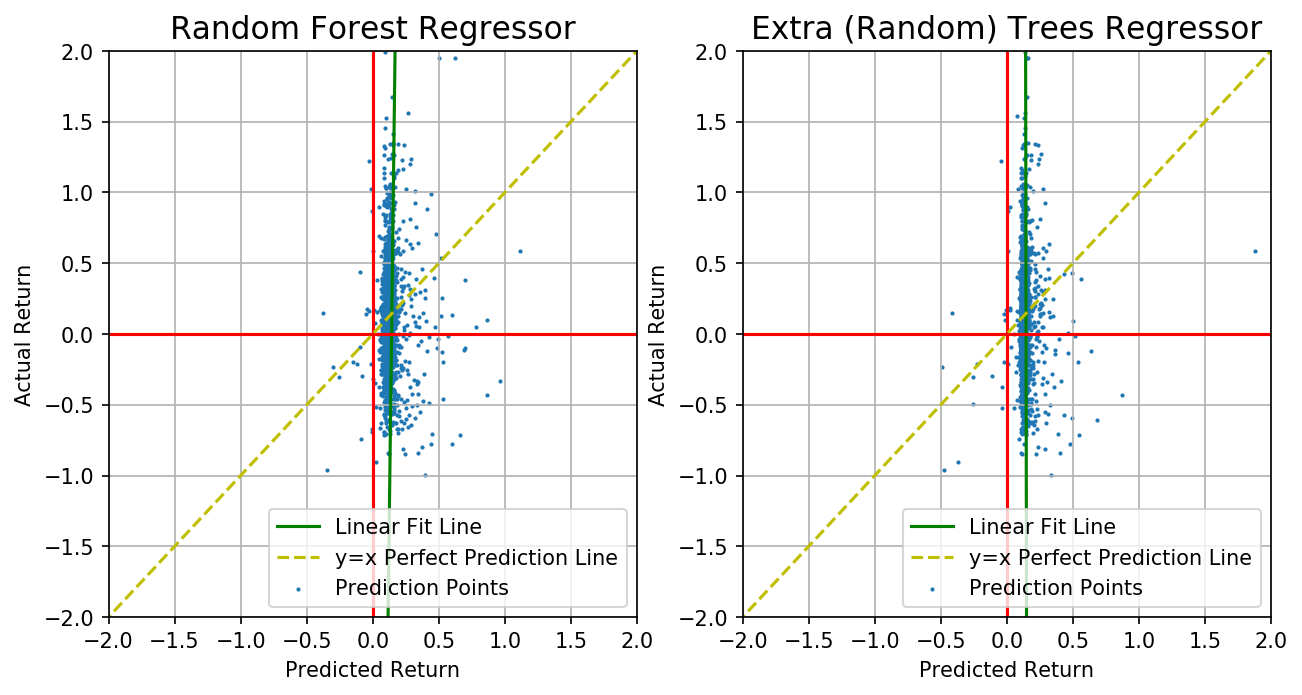

In [81]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plotDensityContourPredVsReal('rfregressor', y_pred, y_test.to_numpy(),2)
plt.title('Random Forest Regressor',fontsize=15)
plt.subplot(1,2,2)
plotDensityContourPredVsReal('ETregressor', y_pred_ET, y_test.to_numpy(),2)
plt.title('Extra (Random) Trees Regressor',fontsize=15)

In [82]:
observePredictionAbility(rfregressor, X, y)

Predicted Performance of Top 10 Return Portfolios: [157.08, 177.49, 80.24, 75.78, 110.5, 220.22, 115.46, 161.29, 99.9, 109.18]
Actual Performance of Top 10 Return Portfolios: [11.95, -6.73, 52.44, 6.65, 86.8, 58.2, -3.98, -17.18, 192.04, 23.25] 

Predicted Performance of Bottom 10 Return Portfolios: [-22.06, -18.51, -14.23, -17.81, -17.63, -11.43, -23.19, -24.85, -21.98, -11.29]
Actual Performance of Bottom 10 Return Portfolios: [9.39, -8.67, -24.27, -43.3, -45.55, 5.55, -11.19, 4.85, -28.39, 36.98]
--------------

Mean Predicted Std. Dev. of Top 10 Return Portfolios: 44.1
Mean Actual Std. Dev. of Top 10 Return Portfolios: 59.46
Mean Predicted Std. Dev. of Bottom 10 Return Portfolios: 4.56
Mean Actual Std. Dev. of Bottom 10 Return Portfolios: 24.42
--------------

Mean Predicted Performance of Top 10 Return Portfolios: 130.71
	Mean Actual Performance of Top 10 Return Portfolios: 40.34
Mean Predicted Performance of Bottom 10 Return Portfolios: -18.3
	Mean Actual Performance of Bottom 10

In [83]:
observePredictionAbility(ETregressor, X, y)

Predicted Performance of Top 10 Return Portfolios: [180.78, 221.47, 104.15, 102.11, 74.79, 130.72, 46.62, 163.62, 98.11, 151.49]
Actual Performance of Top 10 Return Portfolios: [-9.62, -25.17, 16.58, -4.43, 66.29, -12.48, -23.02, 4.32, -24.04, 5.6] 

Predicted Performance of Bottom 10 Return Portfolios: [-26.9, -27.32, -10.31, -24.24, -27.04, -17.7, -24.11, -34.47, -30.07, -13.17]
Actual Performance of Bottom 10 Return Portfolios: [-24.13, 3.38, 28.23, 0.27, -41.0, -39.48, 14.11, -7.55, -37.74, 18.37]
--------------

Mean Predicted Std. Dev. of Top 10 Return Portfolios: 49.93
Mean Actual Std. Dev. of Top 10 Return Portfolios: 25.93
Mean Predicted Std. Dev. of Bottom 10 Return Portfolios: 7.19
Mean Actual Std. Dev. of Bottom 10 Return Portfolios: 24.32
--------------

Mean Predicted Performance of Top 10 Return Portfolios: 127.39
	Mean Actual Performance of Top 10 Return Portfolios: -0.6
Mean Predicted Performance of Bottom 10 Return Portfolios: -23.53
	Mean Actual Performance of Bottom

In [84]:
# Can see the importance of each feature in random forest.
ks, scores=[],[]
for k, score in zip(X.keys(), rfregressor.feature_importances_):
    print(k, round(score,3))
    ks.append(k)
    scores.append(score)

EV/EBIT 0.068
Op. In./(NWC+FA) 0.036
P/E 0.041
P/B 0.069
P/S 0.109
Op. In./Interest Expense 0.041
Working Capital Ratio 0.028
RoE 0.051
ROCE 0.092
Debt/Equity 0.025
Debt Ratio 0.037
Cash Ratio 0.036
Asset Turnover 0.048
Gross Profit Margin 0.039
(CA-CL)/TA 0.124
RE/TA 0.085
EBIT/TA 0.044
Book Equity/TL 0.029


Text(0.5, 1.0, 'Random Forest Feature Relative Importance')

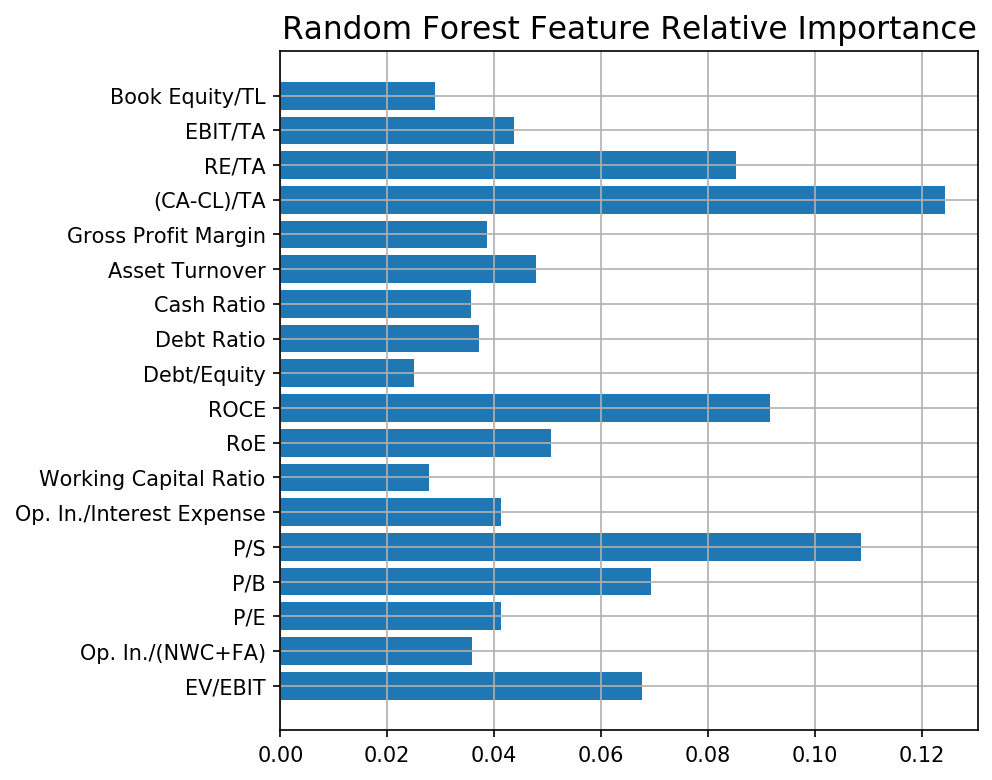

In [85]:
plt.figure(figsize=(6,6))
plt.barh(ks,scores)
plt.grid()
plt.title('Random Forest Feature Relative Importance',fontsize=15)

### Try a different way to visualise results

Text(0.5, 0, 'Sorted list line number\n (Lowest Predictions to the right)')

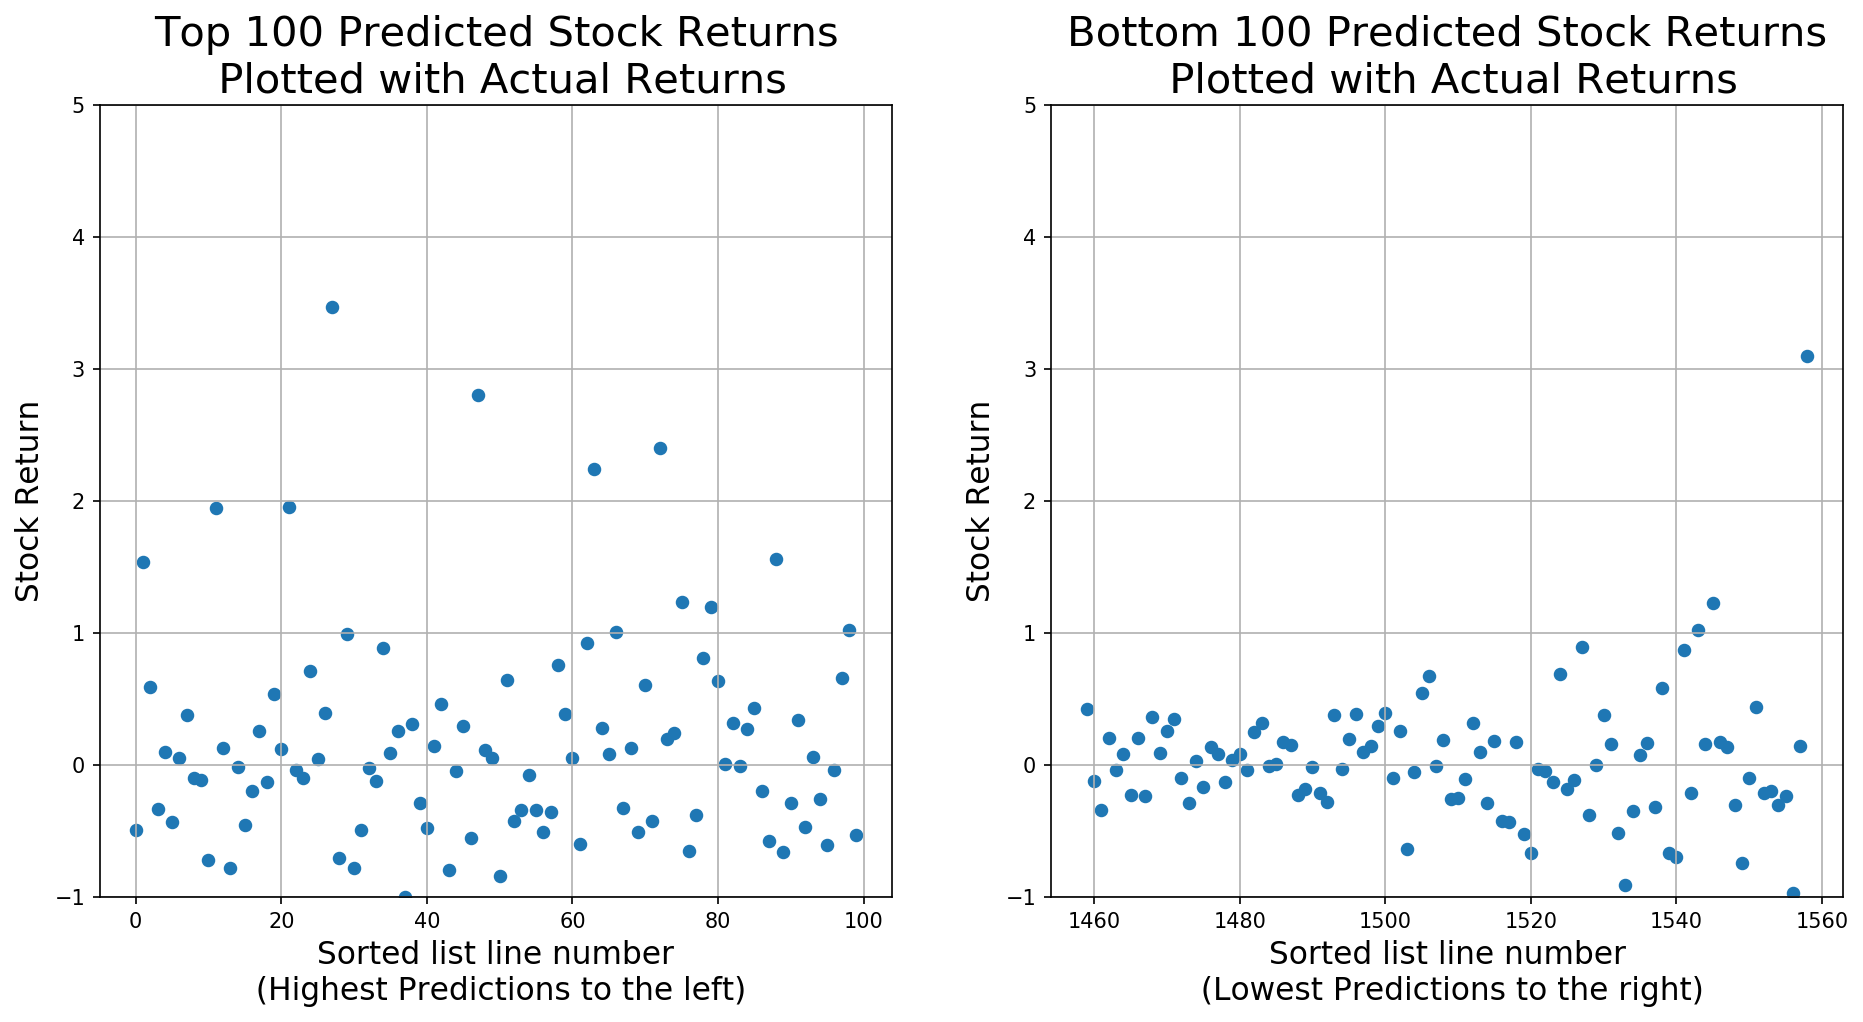

In [86]:
from sklearn.ensemble import RandomForestRegressor
rfregressor = RandomForestRegressor(random_state=42, max_depth=10)
rfregressor.fit(X_train, y_train)
y_pred = rfregressor.predict(X_test)

y_results = pd.DataFrame()
y_results['Actual Return'] = y_test
y_results['Predicted Return'] = y_pred
y_results.sort_values(by='Predicted Return', ascending=False, inplace=True)
y_results.reset_index(drop=True, inplace=True)

endsNum = 100
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
#plt.scatter(y_results.index[:endsNum].values, y_results['Predicted Return'].iloc[:endsNum], s=30)
plt.scatter(y_results.index[:endsNum].values, y_results['Actual Return'].iloc[:endsNum], s=30)
plt.grid()
plt.ylim([-1,5])
plt.title('Top '+str(endsNum)+' Predicted Stock Returns\n Plotted with Actual Returns', fontsize=20)
plt.ylabel('Stock Return', fontsize=15)
plt.xlabel('Sorted list line number\n (Highest Predictions to the left)', fontsize=15)
plt.subplot(1,2,2)
#plt.scatter(y_results.index[-endsNum:].values, y_results['Predicted Return'].iloc[-endsNum:], s=30)
plt.scatter(y_results.index[-endsNum:].values, y_results['Actual Return'].iloc[-endsNum:], s=30)
plt.grid()
plt.ylim([-1,5])
plt.title('Bottom '+str(endsNum)+' Predicted Stock Returns\n Plotted with Actual Returns', fontsize=20)
plt.ylabel('Stock Return', fontsize=15)
plt.xlabel('Sorted list line number\n (Lowest Predictions to the right)', fontsize=15)

# Gradient Boosted Decision Tree Regressor

In [88]:
# Read in data and do train/test split.
X, y = loadXandyAgain()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print('X training matrix dimensions: ', X_train.shape)
print('X testing matrix dimensions: ', X_test.shape)
print('y training matrix dimensions: ', y_train.shape)
print('y testing matrix dimensions: ', y_test.shape)

X training matrix dimensions:  (14029, 18)
X testing matrix dimensions:  (1559, 18)
y training matrix dimensions:  (14029,)
y testing matrix dimensions:  (1559,)


In [89]:
from sklearn.ensemble import GradientBoostingRegressor

pl_GradBregressor = Pipeline([
    ('GradBoostRegressor', GradientBoostingRegressor(n_estimators=100,\
                                                     learning_rate=0.1,\
                                                     max_depth=10,\
                                                     random_state=42,\
                                                     loss='squared_error'))\
])

pl_GradBregressor.fit(X_train, y_train)
y_pred = pl_GradBregressor.predict(X_test)
from sklearn.metrics import mean_squared_error
print('train mse: ', mean_squared_error(y_train, pl_GradBregressor.predict(X_train)))
print('test mse: ', mean_squared_error(y_test, y_pred))

import pickle
pickle.dump(pl_GradBregressor, open("pl_GradBregressor.p", "wb" ))

train mse:  0.05241411099448579
test mse:  0.2729502516200619


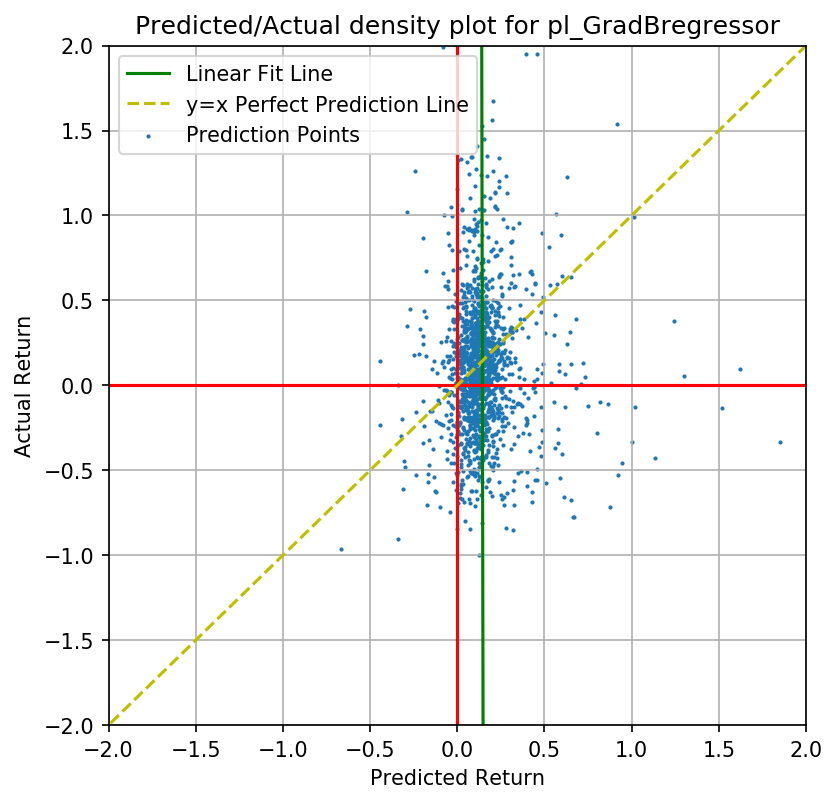

In [90]:
plt.figure(figsize=(6,6))
plotDensityContourPredVsReal('pl_GradBregressor', y_pred, y_test.to_numpy(),2)

In [91]:
# See top 10 stocks and see how the values differ for current train/test split
PrintTopAndBottom10Predictions(y_test, y_pred)


Top 10 Predicted Returns: 1.49 % 

Actual Top 10 Returns: -0.03 % 


Bottom 10 Predicted Returns: -0.4 % 

Actual Bottom 10 Returns: 0.22 % 



In [92]:
observePredictionAbility(pl_GradBregressor, X, y)

Predicted Performance of Top 10 Return Portfolios: [149.18, 294.55, 127.69, 124.5, 340.86, 347.74, 174.92, 248.36, 249.0, 145.52]
Actual Performance of Top 10 Return Portfolios: [-3.32, 32.06, 19.25, 29.11, 30.55, 55.78, 19.69, -20.48, -7.7, 7.85] 

Predicted Performance of Bottom 10 Return Portfolios: [-39.6, -39.87, -38.18, -40.59, -36.45, -43.29, -40.3, -39.87, -42.29, -36.82]
Actual Performance of Bottom 10 Return Portfolios: [22.29, 0.7, -12.49, 17.21, -14.75, -33.35, -24.62, 19.66, 28.17, 11.65]
--------------

Mean Predicted Std. Dev. of Top 10 Return Portfolios: 82.68
Mean Actual Std. Dev. of Top 10 Return Portfolios: 21.4
Mean Predicted Std. Dev. of Bottom 10 Return Portfolios: 2.05
Mean Actual Std. Dev. of Bottom 10 Return Portfolios: 20.45
--------------

Mean Predicted Performance of Top 10 Return Portfolios: 220.23
	Mean Actual Performance of Top 10 Return Portfolios: 16.28
Mean Predicted Performance of Bottom 10 Return Portfolios: -39.73
	Mean Actual Performance of Bottom

# Plot all results

In [81]:
df_best, df_worst = pd.DataFrame(), pd.DataFrame()

# Run all our regressors (might take awhile.)
# We do this so we can plot easily with the pandas library.
# Make sure using the final hyperparameters.
df_best['LinearRegr'], df_worst['LinearRegr']=observePredictionAbility(
    pl_linear, X, y, returnSomething=True, verbose=False)

df_best['ElasticNet'], df_worst['ElasticNet']=observePredictionAbility(
    pl_ElasticNet, X, y, returnSomething=True, verbose=False)

df_best['KNN'], df_worst['KNN']=observePredictionAbility(
    pl_KNeighbors, X, y, returnSomething=True, verbose=False)

df_best['SVR'], df_worst['SVR']=observePredictionAbility(
    pl_svm, X, y, returnSomething=True, verbose=False)

df_best['DecTree'], df_worst['DecTree']=observePredictionAbility(
    pl_decTree, X, y, returnSomething=True, verbose=False)

df_best['RfRegr'], df_worst['RfRegr']=observePredictionAbility(
    rfregressor, X, y, returnSomething=True, verbose=False)

df_best['EtRegr'], df_worst['EtRegr']=observePredictionAbility(
    ETregressor, X, y, returnSomething=True, verbose=False)

df_best['GradbRegr'], df_worst['GradbRegr']=observePredictionAbility(
    pl_GradBregressor, X, y, returnSomething=True, verbose=False)

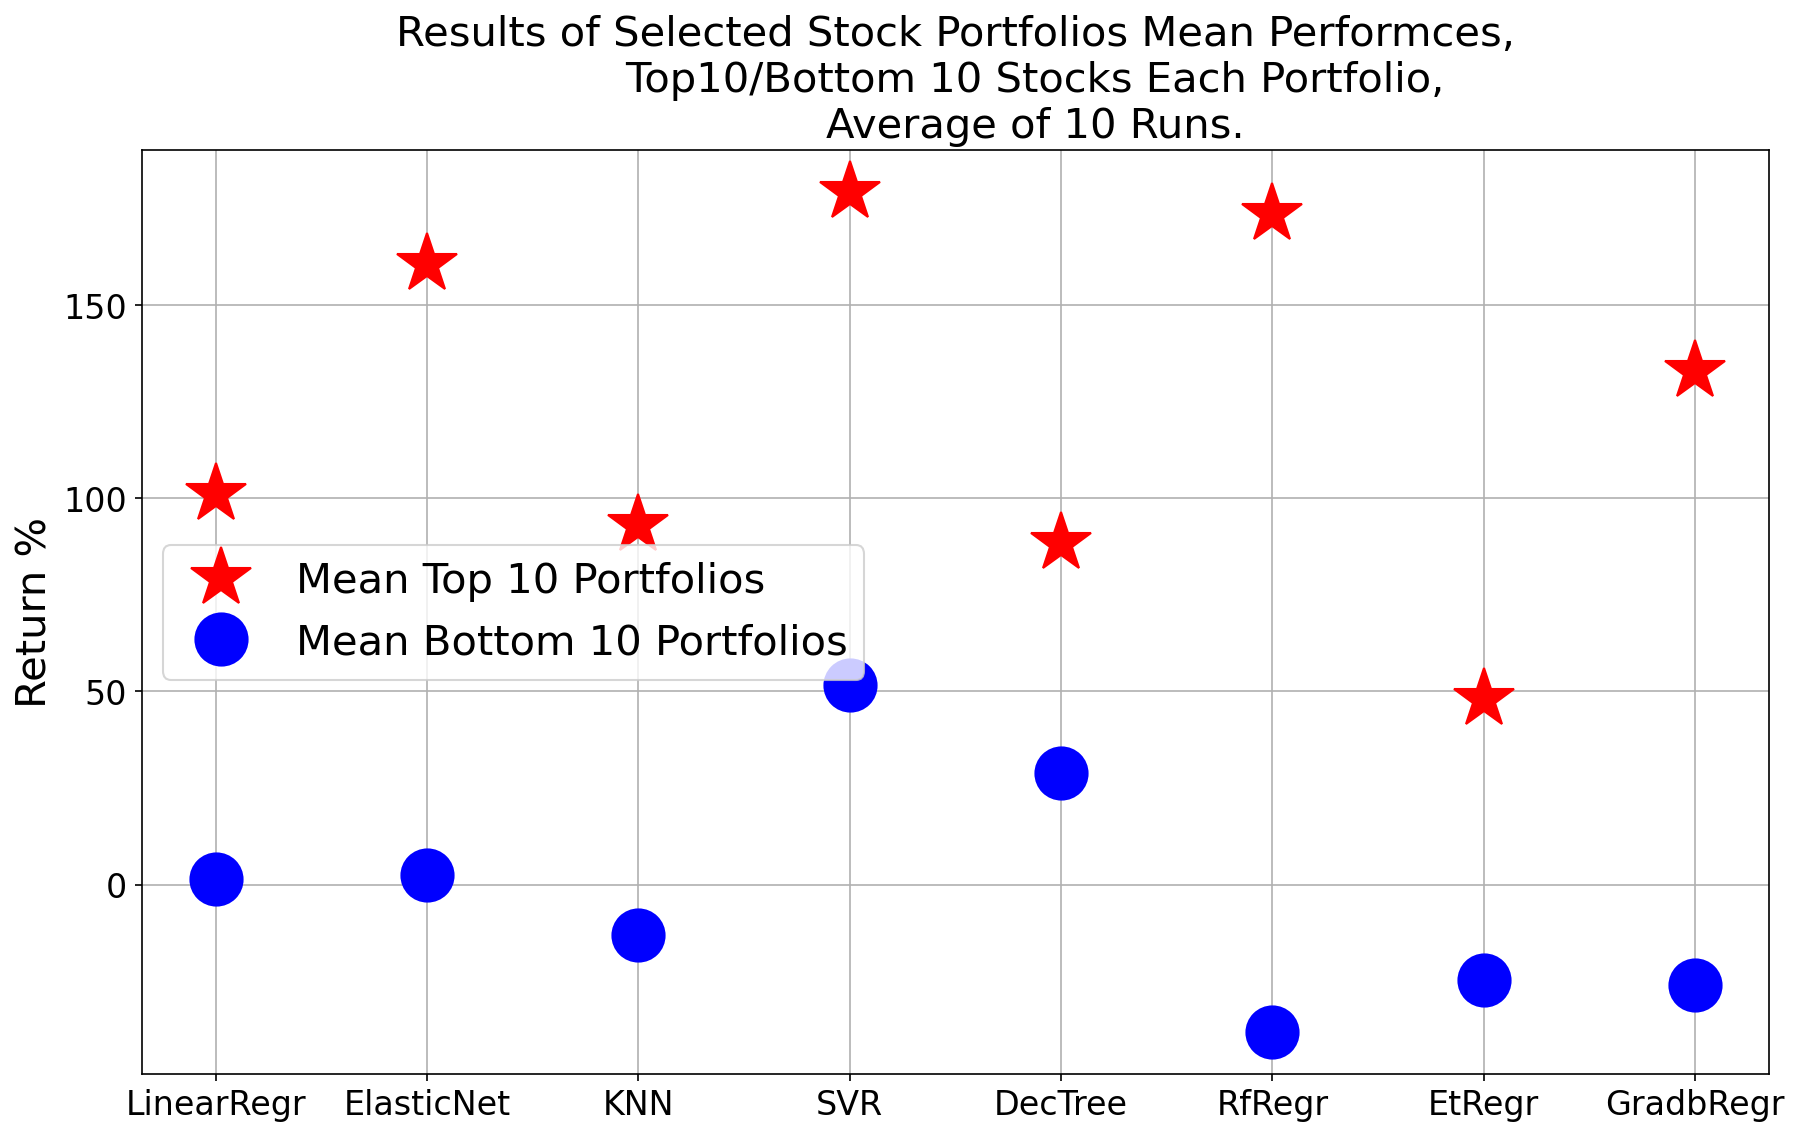

In [83]:
# Plot results out
# Warning: the results are quite variable, 
# we are only looking at the means here.
# Comment out the code to see with standard deviations.

plt.figure(figsize=(14,8))
df_best.mean().plot(linewidth=0, 
                    marker='*', 
                    markersize=30, 
                    markerfacecolor='r', 
                    markeredgecolor='r', 
                    fontsize=16)
#(df_best.mean()+df_best.std()).plot(linewidth=0, marker='*', markersize=10, markerfacecolor='r', markeredgecolor='r')
#(df_best.mean()-df_best.std()).plot(linewidth=0, marker='*', markersize=10, markerfacecolor='r', markeredgecolor='r')
df_worst.mean().plot(linewidth=0, 
                     marker='o', 
                     markersize=25, 
                     markerfacecolor='b', 
                     markeredgecolor='b')
#(df_worst.mean()+df_worst.std()).plot(linewidth=0, marker='o', markersize=10, markerfacecolor='b', markeredgecolor='b')
#(df_worst.mean()-df_worst.std()).plot(linewidth=0, marker='o', markersize=10, markerfacecolor='b', markeredgecolor='b')

plt.legend(['Mean Top 10 Portfolios',
            'Mean Bottom 10 Portfolios'],
           prop={'size': 20})
#plt.ylim([-12, 60])
plt.title('Results of Selected Stock Portfolios Mean Performces,\n\
            Top10/Bottom 10 Stocks Each Portfolio,\n\
            Average of 10 Runs.', fontsize=20)
plt.ylabel('Return %', fontsize=20)
plt.grid()

# Try a hypothetical company and see the prediction

In [ ]:
X.mean()

In [ ]:
y.mean()

In [ ]:
# Put in a dataframe for prediction
avg_company = pd.DataFrame(X.mean().values.reshape(1,-1), columns=X.keys())

In [ ]:
rfregressor.predict(avg_company)

In [ ]:
# Try making a bunch of numbers reflect 
# higher earnings relative to price
good_company = pd.DataFrame(X.mean().values.reshape(1,-1), 
                            columns=X.keys())
good_company['EV/EBIT']=5
good_company['Op. In./(NWC+FA)']=0.4
good_company['P/E']=3
good_company['P/B']=4
good_company['P/S']=13
good_company['EBIT/TA']=1

rfregressor.predict(good_company)

In [ ]:
# Let's try the same in the opposite direction
bad_company = pd.DataFrame(X.mean().values.reshape(1,-1), columns=X.keys())
bad_company['EV/EBIT']=900
bad_company['Op. In./(NWC+FA)']=-0.5
bad_company['P/E']=30
bad_company['P/B']=300
bad_company['P/S']=400
bad_company['EBIT/TA']=0.04

rfregressor.predict(bad_company)